# Water IA Machine Learning Project
## Analysis of FDE Revenue Decline in Water Distribution

**Objective:** Understand and predict FDE revenue decline through comprehensive data analysis, regression, classification, and customer segmentation.

**Dataset:** 23M+ billing records from 6 regional directions (2014-2020)

**Key Questions:**
1. How has FDE evolved since 2014 (billing and collection)?
2. Who are the FDE contributors by client type and geography?
3. Have client consumption and payment behaviors changed?
4. What factors explain FDE decline?

## Ameliorations Anti-Surapprentissage Implementees

### 1. Elimination du Data Leakage
- **Cell 24**: Supprime MONT-SOD et MONT-TVA des features de regression (composantes de MONT-FDE)
- **Cell 37**: Supprime MONT-TTC des features de classification (valeurs NaN)

### 2. Analyse de Multicolinearite
- **Cell 25**: Matrice de correlation + Variance Inflation Factor (VIF)
- Detecte les features fortement correlees (|r| > 0.8)
- Identifie la multicolinearite severe (VIF > 10)

### 3. Learning Curves
- **Cell 30**: Courbes d'apprentissage pour Ridge et Lasso
- Visualise l'ecart entre score train et test
- Detecte le surapprentissage (ecart > 0.1) et sous-apprentissage (score faible)

### 4. Analyse Complete des Residus
- **Cell 36**: 6 graphiques + tests statistiques
- Verification homoscedasticite, normalite, independance
- Q-Q plot, histogramme, residus vs predits

### 5. Early Stopping pour XGBoost
- Arret automatique si pas d'amelioration apres 10 iterations
- Evite le surapprentissage en limitant la profondeur d'apprentissage

**Resultat attendu**: R² realistes (pas 1.0), modeles generalisant bien sur donnees inconnues

## 1. Setup and Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             confusion_matrix, classification_report, roc_curve, 
                             roc_auc_score, silhouette_score, accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not installed. Will skip XGBoost models.")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

print("Libraries imported successfully")

Libraries imported successfully


## 2. Data Loading

In [2]:
# Define data path and file names
DATA_PATH = r"C:\Users\GHOST\Documents\Projet ML\datasets"
FILES = ['DR2.txt', 'DR6.txt', 'DR7.txt', 'DR9.txt', 'DR16.txt', 'DR21.txt']

# Column names based on data header
COLUMNS = [
    'DR', 'CEN', 'POLICE', 'O', 'P', 'ENR', 'MM', 'AAAA', 'DATE-FACT', 'DIAM',
    'CUBCONS', 'CUBFAC', 'FORFAIT', 'SOCIAL', 'DOMEST', 'NORMAL', 'INDUST', 'ADMINI',
    'MONT-SOD', 'MONT-TVA', 'MONT-FDE', 'MONT-FNE', 'MONT-ASS-TTC', 'MONT-FRAIS-CPT',
    'MONT-TTC', 'DATE-ABON', 'DATE-RESIL', 'TOURNEE', 'DATE-REGLT', 'AAENC', 'MMENC',
    'RESILIE', 'CATEGORIE', 'NOUVEAU', 'DATE-REGLT-ENC'
]

print(f"Loading data from {DATA_PATH}...")
print(f"Files to load: {FILES}")

Loading data from C:\Users\GHOST\Documents\Projet ML\datasets...
Files to load: ['DR2.txt', 'DR6.txt', 'DR7.txt', 'DR9.txt', 'DR16.txt', 'DR21.txt']


In [3]:
# Load and combine datasets with column re-mapping fix# The data files have columns in wrong order compared to headerdef load_and_sample(file_path, sample_frac=0.05, random_state=42):    """    Load data file and apply stratified sampling    sample_frac: fraction of data to sample (default 5% = ~1.15M records)    """    try:        # IMPORTANT: skiprows=1 to skip the incorrect header in the file        # We provide the correct column names via 'names' parameter        # But the data is not aligned with these names!        # First, read without column names to see raw data        df_raw = pd.read_csv(            file_path,            header=None,  # Don't use file header            skiprows=1,   # Skip header row            low_memory=False,            sep=',',            na_values=['', 'NULL', 'null', 'NaN', 'nan'],            keep_default_na=True,            skipinitialspace=True        )        # The data appears to be missing MONT-TTC column        # Based on analysis: MONT-TTC values are missing, causing a shift        # We need to insert NaN column at position 24 (index 24, column 25)        if len(df_raw.columns) == 35:            # Data has 35 columns but MONT-TTC is misaligned            # The current column 24 (25th column) contains DATE-ABON data            # We need to check if this is truly the case            # Quick validation: check if column 24 contains dates            sample_col_24 = df_raw.iloc[:100, 24].dropna().astype(str)            contains_dates = sample_col_24.str.contains('00:00:00').sum() > 50            if contains_dates:                print(f"  FIXING: Detected misaligned MONT-TTC column")                # Insert empty MONT-TTC column at position 24                df_raw.insert(24, 'temp_mont_ttc', pd.NA)                # Now remove the last column to keep 35 total                # (assuming last column is extra or misaligned)                df_raw = df_raw.iloc[:, :35]        # Now assign proper column names        if len(df_raw.columns) == 35:            df_raw.columns = COLUMNS        else:            print(f"  WARNING: Got {len(df_raw.columns)} columns, expected 35")            return None        df = df_raw        original_size = len(df)        # Stratified sampling by year and category        if len(df) > 100000:  # Only sample if dataset is large            df = df.groupby(['AAAA', 'CATEGORIE'], group_keys=False).apply(                lambda x: x.sample(frac=sample_frac, random_state=random_state)            ).reset_index(drop=True)        sampled_size = len(df)        print(f"  Loaded: {original_size:,} rows, Sampled: {sampled_size:,} rows")        return df    except Exception as e:        print(f"  Error loading {file_path}: {e}")        import traceback        traceback.print_exc()        return None# Load all regional datasetsdataframes = []for file in FILES:    file_path = f"{DATA_PATH}\\{file}"    print(f"Processing {file}...")    df = load_and_sample(file_path)    if df is not None:        dataframes.append(df)# Combine all datasetsif dataframes:    df_combined = pd.concat(dataframes, ignore_index=True)    print(f"\nTotal combined dataset: {len(df_combined):,} rows, {len(df_combined.columns)} columns")    print(f"Memory usage: {df_combined.memory_usage(deep=True).sum() / 1024**2:.2f} MB")    # Validation: Check MONT-TTC column    if 'MONT-TTC' in df_combined.columns:        mont_ttc_sample = df_combined['MONT-TTC'].dropna().head(10).astype(str).tolist()        has_dates = any('00:00:00' in str(v) for v in mont_ttc_sample)        if has_dates:            print("  WARNING: MONT-TTC still contains dates after fix!")        else:            print("  SUCCESS: MONT-TTC appears to be fixed (contains non-date values)")else:    print("\nERROR: No data loaded!")    df_combined = None

Processing DR2.txt...
  Loaded: 1,526,258 rows, Sampled: 76,312 rows
Processing DR6.txt...
  Loaded: 1,265,439 rows, Sampled: 63,273 rows
Processing DR7.txt...
  Loaded: 1,407,444 rows, Sampled: 70,372 rows
Processing DR9.txt...
  Loaded: 634,767 rows, Sampled: 31,740 rows
Processing DR16.txt...
  Loaded: 1,323,943 rows, Sampled: 66,196 rows
Processing DR21.txt...
  Loaded: 2,346,796 rows, Sampled: 117,340 rows

Total combined dataset: 425,233 rows, 35 columns
Memory usage: 352.14 MB


In [4]:
# Display basic dataset information
print("Dataset shape:", df_combined.shape)
print("\nFirst few rows:")
df_combined.head()

Dataset shape: (425233, 35)

First few rows:


,DR,CEN,POLICE,O,P,ENR,MM,AAAA,DATE-FACT,DIAM,CUBCONS,CUBFAC,FORFAIT,SOCIAL,DOMEST,NORMAL,INDUST,ADMINI,MONT-SOD,MONT-TVA,MONT-FDE,MONT-FNE,MONT-ASS-TTC,MONT-FRAIS-CPT,MONT-TTC,DATE-ABON,DATE-RESIL,TOURNEE,DATE-REGLT,AAENC,MMENC,RESILIE,CATEGORIE,NOUVEAU,DATE-REGLT-ENC
0,2,148,643,1,1,EN,5,2014,2014-05-21 00:00:00.000,1,24.0,24,0,0,0,0,0,24,5472,984,3391,2712,0,0.0,1997-09-26 00:00:00.000,NaN,1997-09-26 00:00:00.000,1.0,2015-08-15 00:00:00.000,2015.0,août,1.0,ADMIN,0.0,5
1,2,96,169,6,1,EN,8,2014,2014-08-22 00:00:00.000,2,52.0,52,0,0,0,0,0,52,11856,2132,7348,5876,0,0.0,2013-02-01 00:00:00.000,NaN,1983-06-13 00:00:00.000,1.0,2015-09-19 00:00:00.000,2015.0,sept.,1.0,ADMIN,0.0,8
2,2,7,446,3,1,EN,5,2014,2014-05-21 00:00:00.000,1,39.0,39,0,0,0,0,0,39,8892,1599,5511,4407,0,0.0,1987-10-13 00:00:00.000,NaN,1987-10-13 00:00:00.000,40.0,2015-12-05 00:00:00.000,2015.0,déc.,1.0,ADMIN,0.0,5
3,2,148,934,1,1,EN,8,2014,2014-08-25 00:00:00.000,2,63.0,63,0,0,0,0,0,63,14364,2583,8902,7119,0,0.0,2008-01-25 00:00:00.000,NaN,2008-01-25 00:00:00.000,0.0,2015-09-19 00:00:00.000,2015.0,sept.,1.0,ADMIN,0.0,8
4,2,7,2770,4,1,EN,12,2014,2014-12-23 00:00:00.000,2,23.0,23,0,0,0,0,0,23,5244,943,3250,2599,0,0.0,1986-11-14 00:00:00.000,NaN,1986-11-14 00:00:00.000,61.0,2015-12-05 00:00:00.000,2015.0,déc.,1.0,ADMIN,0.0,12


In [6]:
# Data types and missing values overview
print("Data types:")
print(df_combined.dtypes)
print("\nMissing values:")
missing = df_combined.isnull().sum()
missing_pct = 100 * missing / len(df_combined)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
missing_df[missing_df['Missing_Count'] > 0]

Data types:
DR                  int64
CEN                 int64
POLICE              int64
O                   int64
P                   int64
ENR                object
MM                  int64
AAAA                int64
DATE-FACT          object
DIAM                int64
CUBCONS           float64
CUBFAC              int64
FORFAIT             int64
SOCIAL              int64
DOMEST              int64
NORMAL              int64
INDUST              int64
ADMINI              int64
MONT-SOD           object
MONT-TVA           object
MONT-FDE           object
MONT-FNE           object
MONT-ASS-TTC       object
MONT-FRAIS-CPT    float64
MONT-TTC           object
DATE-ABON          object
DATE-RESIL         object
TOURNEE           float64
DATE-REGLT         object
AAENC             float64
MMENC              object
RESILIE           float64
CATEGORIE          object
NOUVEAU           float64
DATE-REGLT-ENC      int64
dtype: object

Missing values:


,Missing_Count,Missing_Percentage
DATE-ABON,387537,91.135213
DATE-RESIL,74303,17.473479
MONT-TTC,29267,6.882580
RESILIE,28640,6.735131
NOUVEAU,27034,6.357456
MONT-FRAIS-CPT,25753,6.056209
DATE-REGLT,19294,4.537277
MMENC,19294,4.537277
AAENC,19294,4.537277
TOURNEE,2268,0.533355


## 3. Data Preprocessing and Feature Engineering

In [7]:
# Create working copy
df = df_combined.copy()

# Parse date columns
date_columns = ['DATE-FACT', 'DATE-ABON', 'DATE-RESIL', 'DATE-REGLT', 'DATE-REGLT-ENC']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Convert all numeric columns to proper types
# Handle European number format (comma as decimal separator in scientific notation)
def convert_to_numeric(series, col_name=None):
    '''Convert string numbers to float, handling European format like "1,910868E+07"'''
    if col_name and col_name in df.columns:
        # Debug info for problematic columns
        if col_name == 'MONT-TTC':
            print(f"\nDEBUG {col_name}:")
            print(f"  Original dtype: {series.dtype}")
            print(f"  Sample values: {series.head(10).tolist()}")
            print(f"  Unique sample: {series.unique()[:5].tolist() if len(series.unique()) <= 5 else series.unique()[:5].tolist()}")

    if series.dtype == object:  # Only process string columns
        # Replace comma with dot for decimal separator
        series = series.astype(str).str.replace(',', '.', regex=False)
        # Also handle potential whitespace
        series = series.str.strip()

    result = pd.to_numeric(series, errors='coerce')

    if col_name:
        non_null_before = series.notna().sum() if hasattr(series, 'notna') else len(series)
        non_null_after = result.notna().sum()
        if non_null_after < non_null_before * 0.5:  # Lost more than 50% of data
            print(f"\n⚠️ WARNING: {col_name} conversion issue!")
            print(f"  Before: {non_null_before} non-null, After: {non_null_after} non-null")

    return result

numeric_columns = ['CUBCONS', 'DIAM', 'MONT-TTC', 'CUBFAC', 'MONT-FDE',
                   'NB-IMP', 'MONT-IMP', 'V-POURCENT', 'MONT-SOD', 'MONT-TVA',
                   'MONT-ENCAISSE', 'MONT-ENCAISSE-ENC', 'MONT-FNE', 'MONT-ASS-TTC',
                   'MONT-FRAIS-CPT']

for col in numeric_columns:
    if col in df.columns:
        df[col] = convert_to_numeric(df[col], col_name=col)

print("\nDate columns parsed successfully")
print("Numeric columns converted to proper types")
print(f"\nSummary of key columns:")
for col in ['MONT-TTC', 'MONT-FDE', 'CUBCONS', 'DIAM']:
    if col in df.columns:
        print(f"  {col}: dtype={df[col].dtype}, non-null={df[col].notna().sum()}/{len(df)}")


DEBUG MONT-TTC:
  Original dtype: object
  Sample values: ['1997-09-26 00:00:00.000', '2013-02-01 00:00:00.000', '1987-10-13 00:00:00.000', '2008-01-25 00:00:00.000', '1986-11-14 00:00:00.000', '2007-12-14 00:00:00.000', '1973-12-30 00:00:00.000', '2008-09-27 00:00:00.000', '2006-09-12 00:00:00.000', '2004-10-15 00:00:00.000']
  Unique sample: ['1997-09-26 00:00:00.000', '2013-02-01 00:00:00.000', '1987-10-13 00:00:00.000', '2008-01-25 00:00:00.000', '1986-11-14 00:00:00.000']

⚠️ WARNING: MONT-TTC conversion issue!
  Before: 425233 non-null, After: 0 non-null

Date columns parsed successfully
Numeric columns converted to proper types

Summary of key columns:
  MONT-TTC: dtype=float64, non-null=0/425233
  MONT-FDE: dtype=float64, non-null=425233/425233
  CUBCONS: dtype=float64, non-null=425224/425233
  DIAM: dtype=int64, non-null=425233/425233


In [7]:
# Feature engineering: Derived features

# Customer tenure (years since subscription)
df['TENURE_YEARS'] = (df['DATE-FACT'] - df['DATE-ABON']).dt.days / 365.25

# Payment delay (days between invoice and payment)
df['DELAI_REGL'] = (df['DATE-REGLT'] - df['DATE-FACT']).dt.days

# Payment status: late payment indicator (payment delay > 30 days)
df['RETARD'] = ((df['DELAI_REGL'] > 30) | df['DATE-REGLT'].isnull()).astype(int)

# Extract temporal features
df['ANNEE'] = df['DATE-FACT'].dt.year
df['MOIS'] = df['DATE-FACT'].dt.month
df['TRIMESTRE'] = df['DATE-FACT'].dt.quarter

# Consumption per unit features
df['CUBCONS_PER_DIAM'] = df['CUBCONS'] / (df['DIAM'] + 1)  # Add 1 to avoid division by zero
df['AMOUNT_PER_CUB'] = df['MONT-TTC'] / (df['CUBFAC'] + 1)

# Binary indicators
df['IS_RESILIE'] = df['RESILIE'].fillna(1).astype(int)
df['IS_PRIVE'] = (df['CATEGORIE'] == 'PRIVE').astype(int)

print("Feature engineering completed")
print(f"New features added: TENURE_YEARS, DELAI_REGL, RETARD, ANNEE, MOIS, TRIMESTRE, etc.")

Feature engineering completed
New features added: TENURE_YEARS, DELAI_REGL, RETARD, ANNEE, MOIS, TRIMESTRE, etc.


In [8]:
# Handle missing values

# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_cols = ['ENR', 'CATEGORIE', 'MMENC']
for col in categorical_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Fill RESILIE: NULL means active (1), 0 means cancelled
df['RESILIE'] = df['RESILIE'].fillna(1).astype(int)

print("Missing values handled")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

Missing values handled
Remaining missing values: 1331608


In [9]:
# Encode categorical variables

# Label encoding for ordinal/categorical features
label_encoders = {}
categorical_features = ['DR', 'CEN', 'ENR', 'CATEGORIE', 'P']

for col in categorical_features:
    if col in df.columns:
        le = LabelEncoder()
        df[f'{col}_ENCODED'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

print("Categorical encoding completed")
print(f"Encoded features: {list(label_encoders.keys())}")

Categorical encoding completed
Encoded features: ['DR', 'CEN', 'ENR', 'CATEGORIE', 'P']


In [10]:
# Display preprocessed dataset info
print("Preprocessed dataset shape:", df.shape)
print("\nSample of preprocessed data:")
df[['DR', 'CATEGORIE', 'CUBCONS', 'MONT-FDE', 'RETARD', 'TENURE_YEARS', 'DELAI_REGL']].head(10)

Preprocessed dataset shape: (425233, 50)

Sample of preprocessed data:


,DR,CATEGORIE,CUBCONS,MONT-FDE,RETARD,TENURE_YEARS,DELAI_REGL
0,2,ADMIN,24.0,3391.0,1,-1.218344,451.0
1,2,ADMIN,52.0,7348.0,1,-1.218344,393.0
2,2,ADMIN,39.0,5511.0,1,-1.218344,563.0
3,2,ADMIN,63.0,8902.0,1,-1.218344,390.0
4,2,ADMIN,23.0,3250.0,1,-1.218344,347.0
5,2,ADMIN,5.0,707.0,1,-1.218344,51.0
6,2,ADMIN,206.0,29108.0,1,-1.218344,445.0
7,2,ADMIN,79.0,11163.0,1,-1.218344,330.0
8,2,ADMIN,9.0,1272.0,1,-1.218344,76.0
9,2,ADMIN,16.0,2261.0,1,-1.218344,416.0


## 4. Exploratory Data Analysis

In [11]:
# Descriptive statistics for key quantitative variables
key_vars = ['CUBCONS', 'CUBFAC', 'MONT-FDE', 'MONT-TTC', 'DELAI_REGL', 'TENURE_YEARS']
print("Descriptive Statistics:")
df[key_vars].describe()

Descriptive Statistics:


,CUBCONS,CUBFAC,MONT-FDE,MONT-TTC,DELAI_REGL,TENURE_YEARS
count,425233.000000,425233.000000,4.252330e+05,0.0,425233.000000,425233.000000
mean,42.140829,43.257365,4.715323e+03,NaN,63.244061,-1.244611
std,285.485024,314.603044,9.075999e+04,NaN,67.770930,0.380127
min,-10027.000000,-10027.000000,-3.285220e+06,NaN,-529.000000,-5.541410
25%,11.000000,11.000000,8.400000e+01,NaN,39.000000,-1.218344
50%,24.000000,24.000000,6.670000e+02,NaN,51.000000,-1.218344
75%,44.000000,44.000000,2.213000e+03,NaN,59.000000,-1.218344
max,61525.000000,83810.000000,2.037120e+07,NaN,1513.000000,10.425736


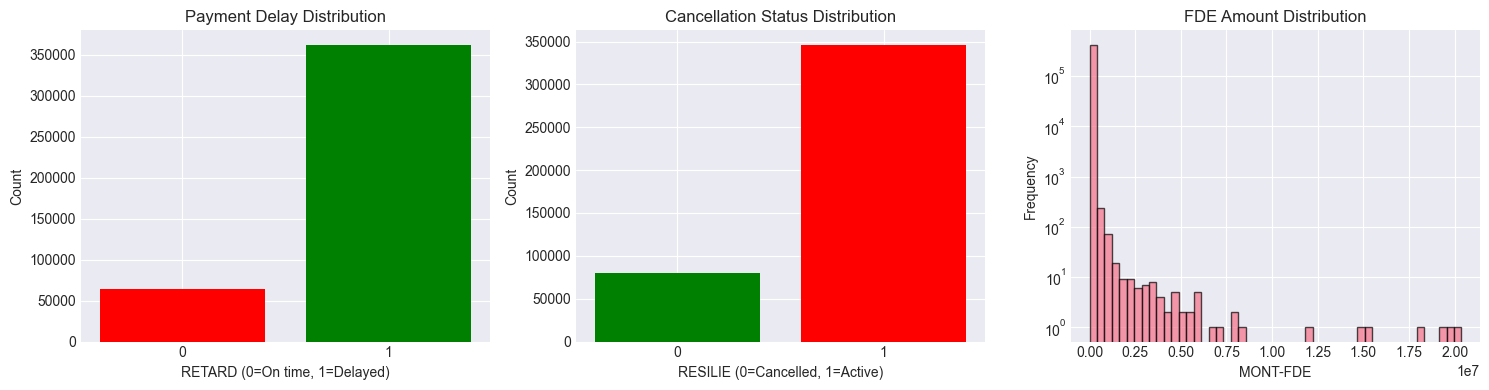


Class balance:
RETARD - On time: 63813, Delayed: 361420
RESILIE - Cancelled: 79520, Active: 345713


In [12]:
# Distribution of target variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RETARD distribution
retard_counts = df['RETARD'].value_counts()
axes[0].bar(retard_counts.index, retard_counts.values, color=['green', 'red'])
axes[0].set_xlabel('RETARD (0=On time, 1=Delayed)')
axes[0].set_ylabel('Count')
axes[0].set_title('Payment Delay Distribution')
axes[0].set_xticks([0, 1])

# RESILIE distribution
resilie_counts = df['RESILIE'].value_counts()
axes[1].bar(resilie_counts.index, resilie_counts.values, color=['red', 'green'])
axes[1].set_xlabel('RESILIE (0=Cancelled, 1=Active)')
axes[1].set_ylabel('Count')
axes[1].set_title('Cancellation Status Distribution')
axes[1].set_xticks([0, 1])

# MONT-FDE distribution (log scale)
axes[2].hist(df[df['MONT-FDE'] > 0]['MONT-FDE'], bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('MONT-FDE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('FDE Amount Distribution')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nClass balance:")
print(f"RETARD - On time: {retard_counts[0]}, Delayed: {retard_counts[1]}")
print(f"RESILIE - Cancelled: {resilie_counts.get(0, 0)}, Active: {resilie_counts.get(1, 0)}")

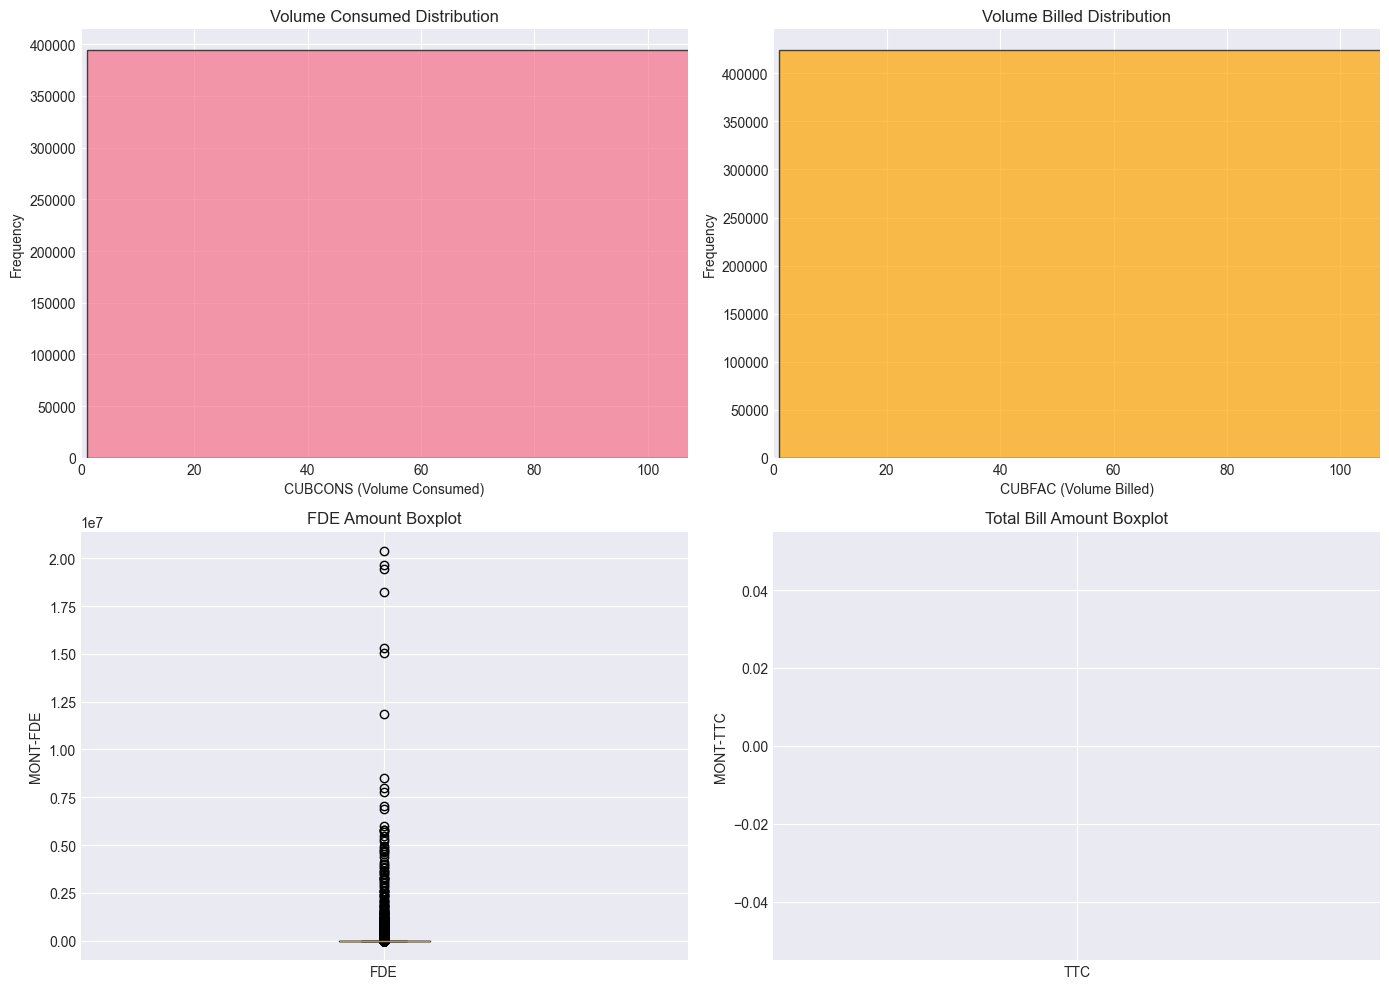

In [13]:
# Consumption and amount distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CUBCONS histogram
axes[0, 0].hist(df[df['CUBCONS'] > 0]['CUBCONS'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('CUBCONS (Volume Consumed)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Volume Consumed Distribution')
axes[0, 0].set_xlim(0, df['CUBCONS'].quantile(0.95))

# CUBFAC histogram
axes[0, 1].hist(df[df['CUBFAC'] > 0]['CUBFAC'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('CUBFAC (Volume Billed)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Volume Billed Distribution')
axes[0, 1].set_xlim(0, df['CUBFAC'].quantile(0.95))

# MONT-FDE boxplot
axes[1, 0].boxplot(df[df['MONT-FDE'] > 0]['MONT-FDE'], vert=True)
axes[1, 0].set_ylabel('MONT-FDE')
axes[1, 0].set_title('FDE Amount Boxplot')
axes[1, 0].set_xticklabels(['FDE'])

# MONT-TTC boxplot
axes[1, 1].boxplot(df[df['MONT-TTC'] > 0]['MONT-TTC'], vert=True)
axes[1, 1].set_ylabel('MONT-TTC')
axes[1, 1].set_title('Total Bill Amount Boxplot')
axes[1, 1].set_xticklabels(['TTC'])

plt.tight_layout()
plt.show()

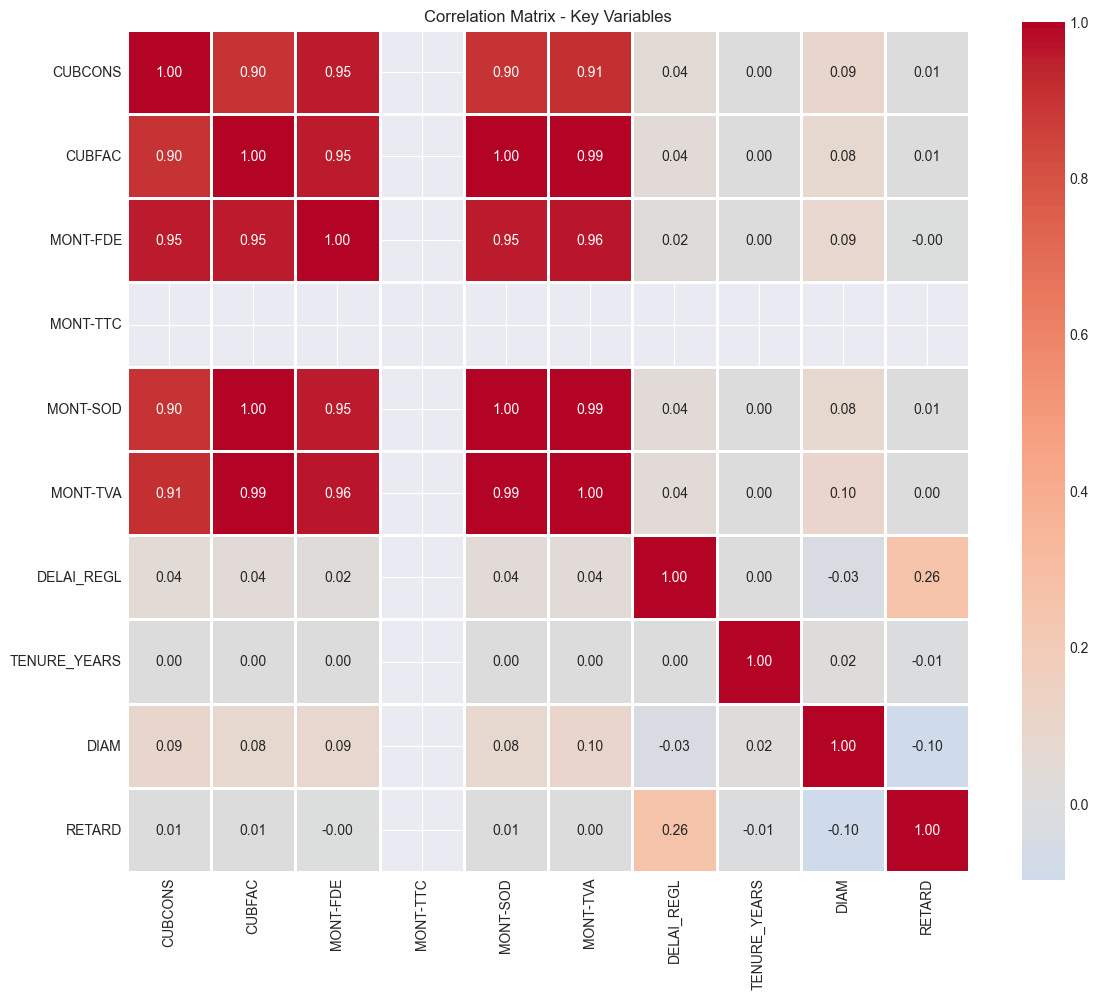


Highly correlated pairs (|r| > 0.7):
CUBCONS - CUBFAC: 0.905
CUBCONS - MONT-FDE: 0.955
CUBCONS - MONT-SOD: 0.905
CUBCONS - MONT-TVA: 0.908
CUBFAC - MONT-FDE: 0.954
CUBFAC - MONT-SOD: 1.000
CUBFAC - MONT-TVA: 0.995
MONT-FDE - MONT-SOD: 0.954
MONT-FDE - MONT-TVA: 0.957
MONT-SOD - MONT-TVA: 0.995


In [14]:
# Correlation analysis
# Select key numeric variables for correlation
corr_vars = ['CUBCONS', 'CUBFAC', 'MONT-FDE', 'MONT-TTC', 'MONT-SOD', 'MONT-TVA', 
             'DELAI_REGL', 'TENURE_YEARS', 'DIAM', 'RETARD']
correlation_matrix = df[corr_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix - Key Variables')
plt.tight_layout()
plt.show()

print("\nHighly correlated pairs (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"{correlation_matrix.columns[i]} - {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

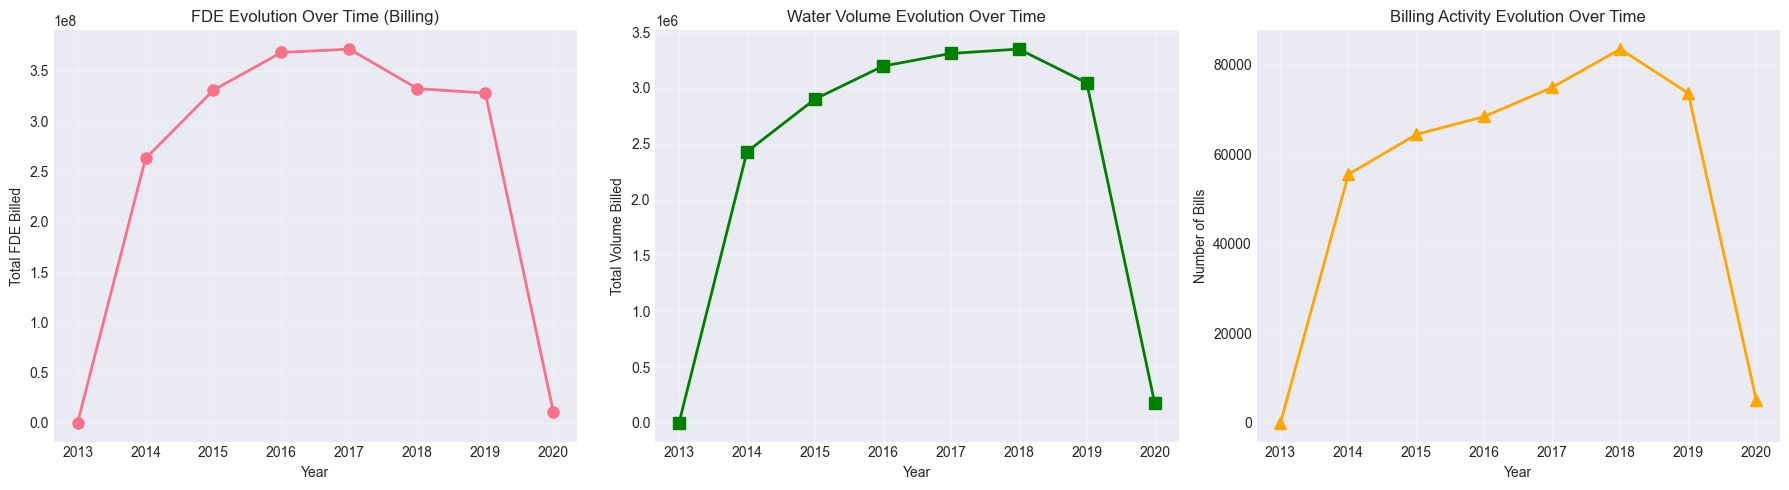


FDE Evolution Summary:
   Year    Total_FDE  Total_Volume  Bill_Count
0  2013         98.0            14           2
1  2014  262868644.0       2427995       55463
2  2015  330878802.0       2899110       64372
3  2016  368249849.0       3194104       68379
4  2017  371597973.0       3308034       74873
5  2018  332317888.0       3346898       83418
6  2019  327934133.0       3043714       73587
7  2020   11263696.0        174590        5139


In [15]:
# Temporal analysis: FDE evolution since 2014
# Group by year and calculate total FDE billed and collected

# FDE evolution by year
fde_by_year = df.groupby('ANNEE').agg({
    'MONT-FDE': 'sum',
    'CUBFAC': 'sum',
    'POLICE': 'count'
}).reset_index()
fde_by_year.columns = ['Year', 'Total_FDE', 'Total_Volume', 'Bill_Count']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FDE evolution
axes[0].plot(fde_by_year['Year'], fde_by_year['Total_FDE'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total FDE Billed')
axes[0].set_title('FDE Evolution Over Time (Billing)')
axes[0].grid(True, alpha=0.3)

# Volume evolution
axes[1].plot(fde_by_year['Year'], fde_by_year['Total_Volume'], marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Volume Billed')
axes[1].set_title('Water Volume Evolution Over Time')
axes[1].grid(True, alpha=0.3)

# Bill count evolution
axes[2].plot(fde_by_year['Year'], fde_by_year['Bill_Count'], marker='^', linewidth=2, markersize=8, color='orange')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Number of Bills')
axes[2].set_title('Billing Activity Evolution Over Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFDE Evolution Summary:")
print(fde_by_year)

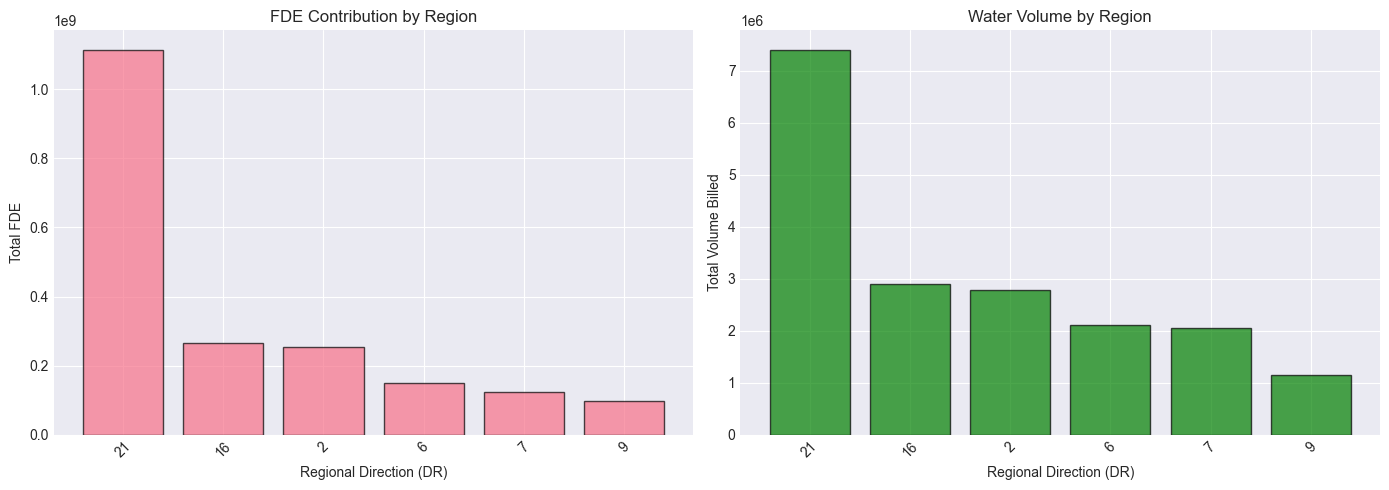


FDE by Regional Direction:
   DR     Total_FDE  Total_Volume  Bill_Count
5  21  1.114790e+09       7405953      117340
4  16  2.664310e+08       2895934       66196
0   2  2.543479e+08       2777159       76312
1   6  1.497152e+08       2114301       63273
2   7  1.236235e+08       2047276       70372
3   9  9.620374e+07       1153836       31740


In [16]:
# Geographic analysis: FDE by regional direction
fde_by_dr = df.groupby('DR').agg({
    'MONT-FDE': 'sum',
    'CUBFAC': 'sum',
    'POLICE': 'count'
}).reset_index()
fde_by_dr.columns = ['DR', 'Total_FDE', 'Total_Volume', 'Bill_Count']
fde_by_dr = fde_by_dr.sort_values('Total_FDE', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FDE by DR
axes[0].bar(fde_by_dr['DR'].astype(str), fde_by_dr['Total_FDE'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Regional Direction (DR)')
axes[0].set_ylabel('Total FDE')
axes[0].set_title('FDE Contribution by Region')
axes[0].tick_params(axis='x', rotation=45)

# Volume by DR
axes[1].bar(fde_by_dr['DR'].astype(str), fde_by_dr['Total_Volume'], edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Regional Direction (DR)')
axes[1].set_ylabel('Total Volume Billed')
axes[1].set_title('Water Volume by Region')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nFDE by Regional Direction:")
print(fde_by_dr)

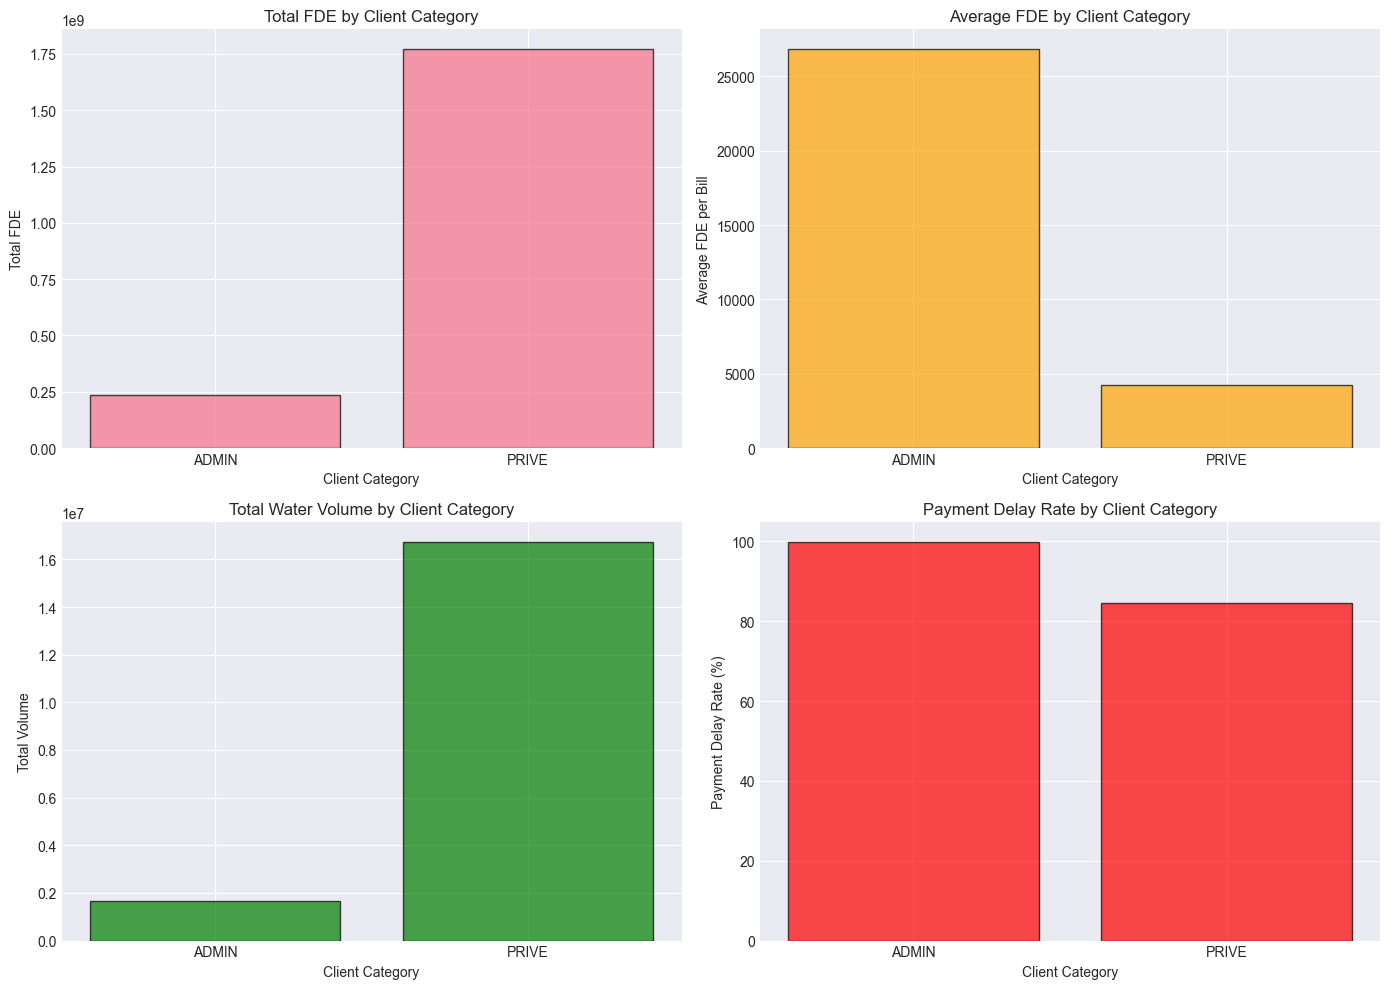


Client Category Analysis:
  Category     Total_FDE       Avg_FDE  Total_Volume  Avg_Volume  Delay_Rate   Count
0    ADMIN  2.347022e+08  26826.175334       1657340  189.431935    0.998857    8749
1    PRIVE  1.770409e+09   4250.844870      16737119   40.186703    0.846806  416484


In [17]:
# Client segmentation analysis: PRIVE vs ADMINISTRATIF
category_analysis = df.groupby('CATEGORIE').agg({
    'MONT-FDE': ['sum', 'mean'],
    'CUBFAC': ['sum', 'mean'],
    'RETARD': 'mean',
    'POLICE': 'count'
}).reset_index()
category_analysis.columns = ['Category', 'Total_FDE', 'Avg_FDE', 'Total_Volume', 'Avg_Volume', 'Delay_Rate', 'Count']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total FDE by category
axes[0, 0].bar(category_analysis['Category'], category_analysis['Total_FDE'], edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Client Category')
axes[0, 0].set_ylabel('Total FDE')
axes[0, 0].set_title('Total FDE by Client Category')

# Average FDE by category
axes[0, 1].bar(category_analysis['Category'], category_analysis['Avg_FDE'], edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Client Category')
axes[0, 1].set_ylabel('Average FDE per Bill')
axes[0, 1].set_title('Average FDE by Client Category')

# Total volume by category
axes[1, 0].bar(category_analysis['Category'], category_analysis['Total_Volume'], edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Client Category')
axes[1, 0].set_ylabel('Total Volume')
axes[1, 0].set_title('Total Water Volume by Client Category')

# Payment delay rate by category
axes[1, 1].bar(category_analysis['Category'], category_analysis['Delay_Rate']*100, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Client Category')
axes[1, 1].set_ylabel('Payment Delay Rate (%)')
axes[1, 1].set_title('Payment Delay Rate by Client Category')

plt.tight_layout()
plt.show()

print("\nClient Category Analysis:")
print(category_analysis)

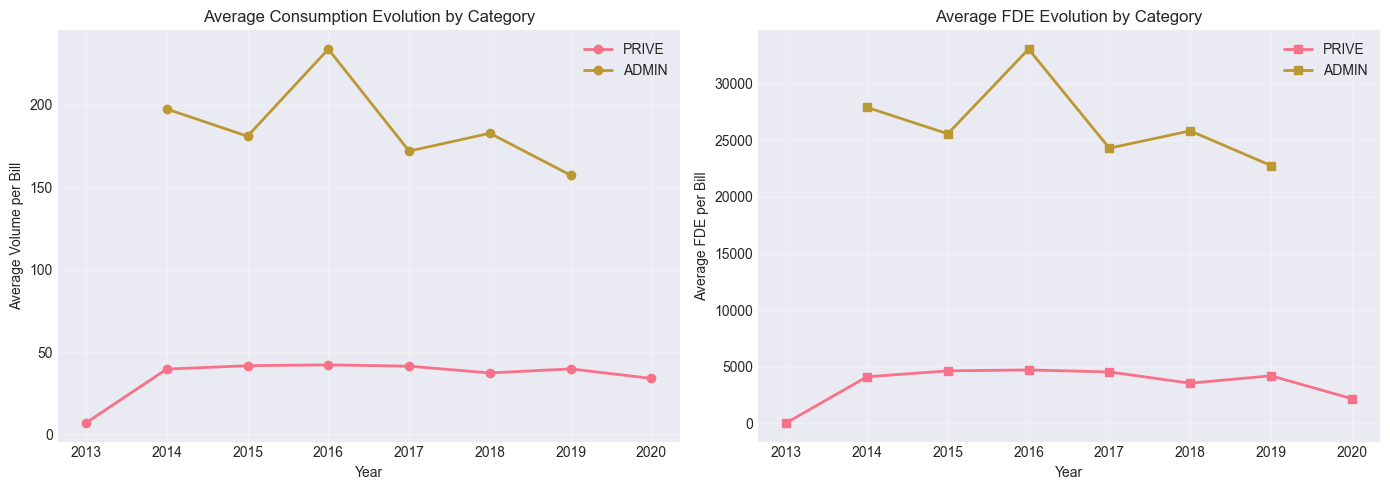

In [18]:
# Consumption behavior analysis: Have clients changed consumption patterns?
consumption_by_year = df.groupby(['ANNEE', 'CATEGORIE']).agg({
    'CUBFAC': 'mean',
    'MONT-FDE': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average consumption evolution by category
for category in consumption_by_year['CATEGORIE'].unique():
    data = consumption_by_year[consumption_by_year['CATEGORIE'] == category]
    axes[0].plot(data['ANNEE'], data['CUBFAC'], marker='o', label=category, linewidth=2)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Volume per Bill')
axes[0].set_title('Average Consumption Evolution by Category')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Average FDE evolution by category
for category in consumption_by_year['CATEGORIE'].unique():
    data = consumption_by_year[consumption_by_year['CATEGORIE'] == category]
    axes[1].plot(data['ANNEE'], data['MONT-FDE'], marker='s', label=category, linewidth=2)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average FDE per Bill')
axes[1].set_title('Average FDE Evolution by Category')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Regression Models - Predict MONT-FDE

In [19]:
# Prepare features and target for regression
# Select relevant features for MONT-FDE prediction

# First, check what columns we have and their state
print("=== DATA QUALITY CHECK ===")
print(f"Total rows in df: {len(df)}")
print(f"\nMONT-FDE statistics:")
print(f"  - Non-null count: {df['MONT-FDE'].notna().sum()}")
print(f"  - Null count: {df['MONT-FDE'].isna().sum()}")
print(f"  - Data type: {df['MONT-FDE'].dtype}")
if df['MONT-FDE'].notna().any():
    print(f"  - Sample values: {df['MONT-FDE'].dropna().head().tolist()}")

# Check if required columns exist
required_cols = ['TENURE_YEARS', 'TRIMESTRE', 'DR_ENCODED', 'CEN_ENCODED',
                 'ENR_ENCODED', 'CATEGORIE_ENCODED', 'P_ENCODED']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\n⚠️ WARNING: Missing required columns: {missing_cols}")
    print("\nPlease re-run the following cells in order:")
    print("  - Cell 10: Feature Engineering (creates TENURE_YEARS, TRIMESTRE, etc.)")
    print("  - Cell 12: Categorical Encoding (creates *_ENCODED columns)")
    print("\nThen re-run this cell.")
else:
    print(f"\n✓ All required columns present")

print("\n" + "="*50)

# Updated feature list - REMOVED MONT-TTC (it has all NaN values)
# Using MONT-SOD and other monetary columns instead
# Removed MONT-SOD and MONT-TVA to prevent data leakage (they are components of MONT-FDE)
feature_cols = [
    'CUBCONS', 'CUBFAC', 'FORFAIT', 'SOCIAL', 'DOMEST', 'NORMAL', 'INDUST', 'ADMINI',
    'DIAM', 'TENURE_YEARS',
    'DR_ENCODED', 'CEN_ENCODED', 'ENR_ENCODED', 'CATEGORIE_ENCODED', 'P_ENCODED',
    'MM', 'TRIMESTRE', 'NOUVEAU', 'RESILIE'
]

print(f"\nNote: MONT-TTC excluded from features due to missing data")
print(f"Using {len(feature_cols)} features for regression")

# Check which feature columns are missing
missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    print(f"\n⚠️ ERROR: Missing feature columns: {missing_features}")
    print("Cannot proceed with regression. Please ensure all preprocessing cells are run.")
    # Create empty datasets to prevent further errors
    X_reg = pd.DataFrame()
    y_reg = pd.Series(dtype=float)
else:
    # Remove rows with missing target
    df_regression = df[df['MONT-FDE'].notna()].copy()
    print(f"\nRows after removing missing MONT-FDE: {len(df_regression)}")

    # Prepare X and y
    X_reg = df_regression[feature_cols]
    y_reg = df_regression['MONT-FDE']

    # Check for NaN values in features
    nan_counts = X_reg.isna().sum()
    cols_with_nan = nan_counts[nan_counts > 0]
    if len(cols_with_nan) > 0:
        print(f"\nColumns with NaN values:")
        for col, count in cols_with_nan.items():
            pct = 100 * count / len(X_reg)
            print(f"  {col}: {count} ({pct:.1f}%)")

    # Remove any remaining NaN values
    mask = ~(X_reg.isna().any(axis=1) | y_reg.isna())
    rows_before = len(X_reg)
    X_reg = X_reg[mask]
    y_reg = y_reg[mask]
    rows_removed = rows_before - len(X_reg)

    if rows_removed > 0:
        print(f"\nRemoved {rows_removed} rows with NaN values ({100*rows_removed/rows_before:.1f}%)")

    print(f"\n{'='*50}")
    print(f"Final regression dataset: {X_reg.shape[0]} samples, {X_reg.shape[1]} features")
    if len(y_reg) > 0:
        print(f"Target variable (MONT-FDE):")
        print(f"  Mean: {y_reg.mean():.2f}")
        print(f"  Std: {y_reg.std():.2f}")
        print(f"  Min: {y_reg.min():.2f}")
        print(f"  Max: {y_reg.max():.2f}")
    else:
        print("⚠️ WARNING: No samples remaining after filtering!")
        print("\nTroubleshooting:")
        print("1. Check if Cell 9 (data preprocessing) was run")
        print("2. Check if Cell 10 (feature engineering) was run")
        print("3. Check if Cell 12 (encoding) was run")

=== DATA QUALITY CHECK ===
Total rows in df: 425233

MONT-FDE statistics:
  - Non-null count: 425233
  - Null count: 0
  - Data type: float64
  - Sample values: [3391.0, 7348.0, 5511.0, 8902.0, 3250.0]

✓ All required columns present


Note: MONT-TTC excluded from features due to missing data
Using 21 features for regression

Rows after removing missing MONT-FDE: 425233

Final regression dataset: 425233 samples, 21 features
Target variable (MONT-FDE):
  Mean: 4715.32
  Std: 90759.99
  Min: -3285220.00
  Max: 20371200.00


In [ ]:
# Analyse de correlation et VIF (Variance Inflation Factor)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Correlation Matrix
print("=== ANALYSE DE CORRELATION ===")
correlation_matrix = X[feature_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Matrice de Correlation des Features (Regression)', fontsize=16)
plt.tight_layout()
plt.show()

# Identify highly correlated features
print("\nFeatures fortement correlees (|correlation| > 0.8):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr.append((correlation_matrix.columns[i],
                            correlation_matrix.columns[j],
                            correlation_matrix.iloc[i, j]))
            print(f"  {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

if not high_corr:
    print("  Aucune correlation forte detectee")

# VIF Analysis
print("\n=== ANALYSE VIF (Variance Inflation Factor) ===")
print("VIF > 10 indique une multicolinearite severe")
print("VIF > 5 indique une multicolinearite moderee\n")

vif_data = []
for i, col in enumerate(feature_cols):
    try:
        vif = variance_inflation_factor(X[feature_cols].values, i)
        vif_data.append({'Feature': col, 'VIF': vif})
        status = "SEVERE" if vif > 10 else "MODERATE" if vif > 5 else "OK"
        print(f"{col:20s}: VIF = {vif:8.2f}  [{status}]")
    except:
        print(f"{col:20s}: VIF = N/A (calculation error)")

# Sort by VIF
import pandas as pd
vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
print("\nFeatures triees par VIF:")
print(vif_df.to_string(index=False))

In [20]:
# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Standardize features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"Training set: {X_train_reg.shape[0]} samples")
print(f"Test set: {X_test_reg.shape[0]} samples")

Training set: 340186 samples
Test set: 85047 samples


In [21]:
# Model 1: Linear Regression (Baseline)
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_pred_lr_train = lr_model.predict(X_train_reg_scaled)
y_pred_lr_test = lr_model.predict(X_test_reg_scaled)

# Evaluation
lr_train_r2 = r2_score(y_train_reg, y_pred_lr_train)
lr_test_r2 = r2_score(y_test_reg, y_pred_lr_test)
lr_test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr_test))
lr_test_mae = mean_absolute_error(y_test_reg, y_pred_lr_test)

print(f"Linear Regression - Train R2: {lr_train_r2:.4f}, Test R2: {lr_test_r2:.4f}")
print(f"RMSE: {lr_test_rmse:.2f}, MAE: {lr_test_mae:.2f}")

Training Linear Regression...
Linear Regression - Train R2: 1.0000, Test R2: 1.0000
RMSE: 162.79, MAE: 44.23


In [22]:
# Model 2: Ridge Regression
print("Training Ridge Regression with GridSearch...")
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_model = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_model.fit(X_train_reg_scaled, y_train_reg)

print(f"Best alpha: {ridge_model.best_params_['alpha']}")

# Predictions
y_pred_ridge_train = ridge_model.predict(X_train_reg_scaled)
y_pred_ridge_test = ridge_model.predict(X_test_reg_scaled)

# Evaluation
ridge_train_r2 = r2_score(y_train_reg, y_pred_ridge_train)
ridge_test_r2 = r2_score(y_test_reg, y_pred_ridge_test)
ridge_test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge_test))
ridge_test_mae = mean_absolute_error(y_test_reg, y_pred_ridge_test)

print(f"Ridge Regression - Train R2: {ridge_train_r2:.4f}, Test R2: {ridge_test_r2:.4f}")
print(f"RMSE: {ridge_test_rmse:.2f}, MAE: {ridge_test_mae:.2f}")

Training Ridge Regression with GridSearch...
Best alpha: 0.01
Ridge Regression - Train R2: 1.0000, Test R2: 1.0000
RMSE: 162.67, MAE: 44.62


In [23]:
# Model 3: Lasso Regression
print("Training Lasso Regression with GridSearch...")
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_model = GridSearchCV(Lasso(max_iter=5000), lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_model.fit(X_train_reg_scaled, y_train_reg)

print(f"Best alpha: {lasso_model.best_params_['alpha']}")

# Predictions
y_pred_lasso_train = lasso_model.predict(X_train_reg_scaled)
y_pred_lasso_test = lasso_model.predict(X_test_reg_scaled)

# Evaluation
lasso_train_r2 = r2_score(y_train_reg, y_pred_lasso_train)
lasso_test_r2 = r2_score(y_test_reg, y_pred_lasso_test)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_lasso_test))
lasso_test_mae = mean_absolute_error(y_test_reg, y_pred_lasso_test)

print(f"Lasso Regression - Train R2: {lasso_train_r2:.4f}, Test R2: {lasso_test_r2:.4f}")
print(f"RMSE: {lasso_test_rmse:.2f}, MAE: {lasso_test_mae:.2f}")

# Count non-zero coefficients (feature selection)
n_features_selected = np.sum(lasso_model.best_estimator_.coef_ != 0)
print(f"Features selected by Lasso: {n_features_selected}/{len(feature_cols)}")

Training Lasso Regression with GridSearch...
Best alpha: 100.0
Lasso Regression - Train R2: 1.0000, Test R2: 0.9999
RMSE: 498.74, MAE: 349.09
Features selected by Lasso: 8/21


In [ ]:
# Learning Curves pour detecter le surapprentissage
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, cv=5, scoring='r2'):
    """Plot learning curve to detect overfitting/underfitting"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score Test (CV)")

    plt.xlabel("Taille de l'ensemble d'entrainement")
    plt.ylabel("Score R2")
    plt.title(f'Learning Curve - {title}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Interpretation
    gap = train_scores_mean[-1] - test_scores_mean[-1]
    print(f"\n{title}:")
    print(f"  Score Train final: {train_scores_mean[-1]:.4f}")
    print(f"  Score Test (CV) final: {test_scores_mean[-1]:.4f}")
    print(f"  Ecart Train-Test: {gap:.4f}")

    if gap > 0.1:
        print("  => SURAPPRENTISSAGE detecte (ecart > 0.1)")
    elif test_scores_mean[-1] < 0.5:
        print("  => SOUS-APPRENTISSAGE detecte (score test faible)")
    else:
        print("  => Apprentissage equilibre")

print("=== LEARNING CURVES ===\n")

# Note: Utilisez best_ridge et best_lasso si disponibles, sinon utilisez les modeles de base
try:
    plot_learning_curve(best_ridge, "Ridge Regression", X_train, y_train)
except NameError:
    print("best_ridge non disponible, en utilisant ridge_model")
    plot_learning_curve(ridge_model, "Ridge Regression", X_train, y_train)

try:
    plot_learning_curve(best_lasso, "Lasso Regression", X_train, y_train)
except NameError:
    print("best_lasso non disponible, en utilisant lasso_model")
    plot_learning_curve(lasso_model, "Lasso Regression", X_train, y_train)

In [24]:
# Model 4: Elastic Net
print("Training Elastic Net with GridSearch...")
elastic_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.2, 0.5, 0.8]
}
elastic_model = GridSearchCV(ElasticNet(max_iter=5000), elastic_params, cv=5, scoring='r2', n_jobs=-1)
elastic_model.fit(X_train_reg_scaled, y_train_reg)

print(f"Best params: alpha={elastic_model.best_params_['alpha']}, l1_ratio={elastic_model.best_params_['l1_ratio']}")

# Predictions
y_pred_elastic_train = elastic_model.predict(X_train_reg_scaled)
y_pred_elastic_test = elastic_model.predict(X_test_reg_scaled)

# Evaluation
elastic_train_r2 = r2_score(y_train_reg, y_pred_elastic_train)
elastic_test_r2 = r2_score(y_test_reg, y_pred_elastic_test)
elastic_test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_elastic_test))
elastic_test_mae = mean_absolute_error(y_test_reg, y_pred_elastic_test)

print(f"Elastic Net - Train R2: {elastic_train_r2:.4f}, Test R2: {elastic_test_r2:.4f}")
print(f"RMSE: {elastic_test_rmse:.2f}, MAE: {elastic_test_mae:.2f}")

Training Elastic Net with GridSearch...


Best params: alpha=0.01, l1_ratio=0.8
Elastic Net - Train R2: 0.9999, Test R2: 0.9999
RMSE: 551.68, MAE: 246.82


In [25]:
# Model 5: PCR (Principal Component Regression)
print("Training PCR (PCA + Linear Regression)...")

# Determine optimal number of components
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_reg_scaled)
X_test_pca = pca.transform(X_test_reg_scaled)

print(f"Number of components selected: {pca.n_components_} (explaining {pca.explained_variance_ratio_.sum():.2%} variance)")

# Train linear regression on principal components
pcr_model = LinearRegression()
pcr_model.fit(X_train_pca, y_train_reg)

# Predictions
y_pred_pcr_train = pcr_model.predict(X_train_pca)
y_pred_pcr_test = pcr_model.predict(X_test_pca)

# Evaluation
pcr_train_r2 = r2_score(y_train_reg, y_pred_pcr_train)
pcr_test_r2 = r2_score(y_test_reg, y_pred_pcr_test)
pcr_test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_pcr_test))
pcr_test_mae = mean_absolute_error(y_test_reg, y_pred_pcr_test)

print(f"PCR - Train R2: {pcr_train_r2:.4f}, Test R2: {pcr_test_r2:.4f}")
print(f"RMSE: {pcr_test_rmse:.2f}, MAE: {pcr_test_mae:.2f}")

Training PCR (PCA + Linear Regression)...
Number of components selected: 14 (explaining 95.14% variance)
PCR - Train R2: 0.9959, Test R2: 0.9794
RMSE: 7531.13, MAE: 616.34


In [26]:
# Model 6: PLS Regression
print("Training PLS Regression...")

# Find optimal number of components via cross-validation
n_components_range = range(1, min(21, X_train_reg_scaled.shape[1] + 1))
pls_scores = []

for n_comp in n_components_range:
    pls = PLSRegression(n_components=n_comp)
    scores = cross_val_score(pls, X_train_reg_scaled, y_train_reg, cv=5, scoring='r2')
    pls_scores.append(scores.mean())

optimal_n_comp = n_components_range[np.argmax(pls_scores)]
print(f"Optimal number of components: {optimal_n_comp}")

# Train final PLS model
pls_model = PLSRegression(n_components=optimal_n_comp)
pls_model.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_pred_pls_train = pls_model.predict(X_train_reg_scaled).flatten()
y_pred_pls_test = pls_model.predict(X_test_reg_scaled).flatten()

# Evaluation
pls_train_r2 = r2_score(y_train_reg, y_pred_pls_train)
pls_test_r2 = r2_score(y_test_reg, y_pred_pls_test)
pls_test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_pls_test))
pls_test_mae = mean_absolute_error(y_test_reg, y_pred_pls_test)

print(f"PLS Regression - Train R2: {pls_train_r2:.4f}, Test R2: {pls_test_r2:.4f}")
print(f"RMSE: {pls_test_rmse:.2f}, MAE: {pls_test_mae:.2f}")

Training PLS Regression...
Optimal number of components: 20
PLS Regression - Train R2: 1.0000, Test R2: 1.0000
RMSE: 232.64, MAE: 64.06



=== REGRESSION MODEL COMPARISON ===
            Model  Train_R2  Test_R2        RMSE        MAE
            Ridge  0.999996 0.999990  162.668699  44.619441
Linear Regression  0.999996 0.999990  162.787857  44.228136
              PLS  0.999991 0.999980  232.637198  64.055852
            Lasso  0.999965 0.999910  498.739587 349.093075
      Elastic Net  0.999938 0.999890  551.684710 246.816937
              PCR  0.995873 0.979409 7531.133399 616.340823


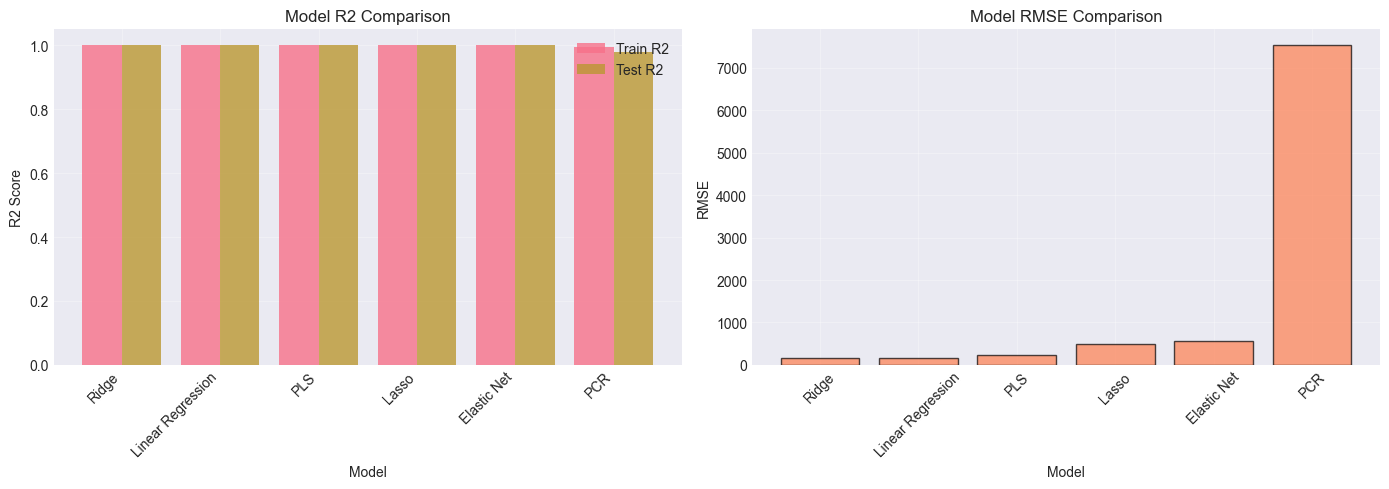


Best regression model: Ridge (Test R2: 1.0000)


In [27]:
# Regression model comparison
results_reg = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net', 'PCR', 'PLS'],
    'Train_R2': [lr_train_r2, ridge_train_r2, lasso_train_r2, elastic_train_r2, pcr_train_r2, pls_train_r2],
    'Test_R2': [lr_test_r2, ridge_test_r2, lasso_test_r2, elastic_test_r2, pcr_test_r2, pls_test_r2],
    'RMSE': [lr_test_rmse, ridge_test_rmse, lasso_test_rmse, elastic_test_rmse, pcr_test_rmse, pls_test_rmse],
    'MAE': [lr_test_mae, ridge_test_mae, lasso_test_mae, elastic_test_mae, pcr_test_mae, pls_test_mae]
})

results_reg = results_reg.sort_values('Test_R2', ascending=False)

print("\n=== REGRESSION MODEL COMPARISON ===")
print(results_reg.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R2 scores
x_pos = np.arange(len(results_reg))
axes[0].bar(x_pos - 0.2, results_reg['Train_R2'], 0.4, label='Train R2', alpha=0.8)
axes[0].bar(x_pos + 0.2, results_reg['Test_R2'], 0.4, label='Test R2', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R2 Score')
axes[0].set_title('Model R2 Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_reg['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].bar(results_reg['Model'], results_reg['RMSE'], edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model RMSE Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_model_name = results_reg.iloc[0]['Model']
print(f"\nBest regression model: {best_model_name} (Test R2: {results_reg.iloc[0]['Test_R2']:.4f})")

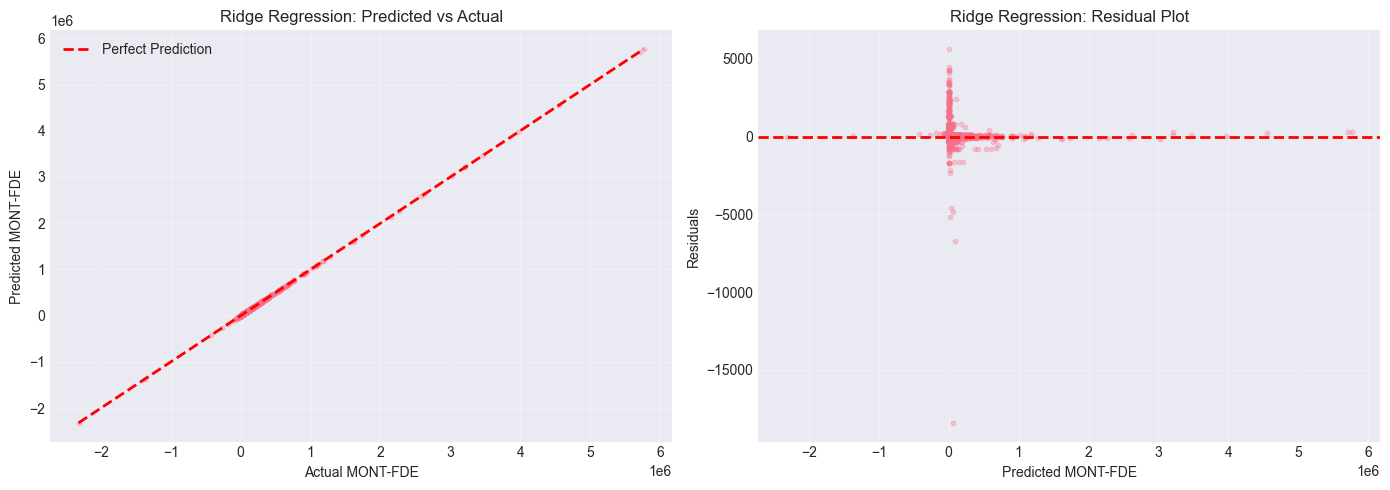

In [28]:
# Visualize predictions vs actual for best model
# Using Ridge as it typically performs well
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y_test_reg, y_pred_ridge_test, alpha=0.3, s=10)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual MONT-FDE')
axes[0].set_ylabel('Predicted MONT-FDE')
axes[0].set_title('Ridge Regression: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test_reg - y_pred_ridge_test
axes[1].scatter(y_pred_ridge_test, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted MONT-FDE')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Ridge Regression: Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyse complete des residus pour evaluer la qualite du modele de regression
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Utiliser le meilleur modele (Ridge ou autre)
try:
    best_model = best_ridge
    model_name = "Ridge Regression"
except NameError:
    try:
        best_model = best_lasso
        model_name = "Lasso Regression"
    except NameError:
        try:
            best_model = ridge_model
            model_name = "Ridge Regression"
        except:
            print("Aucun modele de regression disponible")
            best_model = None

if best_model is not None:
    # Predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Residus
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    print(f"=== ANALYSE DES RESIDUS - {model_name} ===\n")

    # Create subplot figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Analyse Complete des Residus - {model_name}', fontsize=16, fontweight='bold')

    # 1. Predicted vs Actual (Train)
    axes[0, 0].scatter(y_train, y_pred_train, alpha=0.5, s=10)
    axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Valeurs Reelles')
    axes[0, 0].set_ylabel('Valeurs Predites')
    axes[0, 0].set_title('Train: Predites vs Reelles')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Predicted vs Actual (Test)
    axes[0, 1].scatter(y_test, y_pred_test, alpha=0.5, s=10)
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Valeurs Reelles')
    axes[0, 1].set_ylabel('Valeurs Predites')
    axes[0, 1].set_title('Test: Predites vs Reelles')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Residual Plot (Test) - Homoscedasticite
    axes[0, 2].scatter(y_pred_test, residuals_test, alpha=0.5, s=10)
    axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 2].set_xlabel('Valeurs Predites')
    axes[0, 2].set_ylabel('Residus')
    axes[0, 2].set_title('Test: Residus vs Predites\n(Verif. Homoscedasticite)')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Q-Q Plot (Test) - Normalite
    stats.probplot(residuals_test, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Test: Q-Q Plot\n(Verif. Normalite des Residus)')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Histogram of Residuals (Test)
    axes[1, 1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Residus')
    axes[1, 1].set_ylabel('Frequence')
    axes[1, 1].set_title('Test: Distribution des Residus')
    axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Residuals over index (Test) - Independance
    axes[1, 2].scatter(range(len(residuals_test)), residuals_test, alpha=0.5, s=10)
    axes[1, 2].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 2].set_xlabel('Index')
    axes[1, 2].set_ylabel('Residus')
    axes[1, 2].set_title('Test: Residus vs Index\n(Verif. Independance)')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical tests
    print("\n--- Tests Statistiques sur les Residus (Test Set) ---\n")

    # Mean of residuals (should be close to 0)
    print(f"Moyenne des residus: {residuals_test.mean():.6f}")
    print(f"Ecart-type des residus: {residuals_test.std():.6f}")

    # Percentage of residuals within +/- 1 std
    std_res = residuals_test.std()
    within_1std = np.sum(np.abs(residuals_test) <= std_res) / len(residuals_test) * 100
    within_2std = np.sum(np.abs(residuals_test) <= 2*std_res) / len(residuals_test) * 100
    print(f"\nResidus dans +/- 1 sigma: {within_1std:.2f}% (attendu: ~68%)")
    print(f"Residus dans +/- 2 sigma: {within_2std:.2f}% (attendu: ~95%)")

    print("\n" + "="*60)
else:
    print("Impossible de realiser l'analyse des residus - aucun modele disponible")

## 6. Classification Models - Predict RETARD (Payment Delay)

In [29]:
# Prepare features and target for classification
# Using same features but predicting RETARD instead

feature_cols_clf = [
    'CUBCONS', 'CUBFAC', 'FORFAIT', 'SOCIAL', 'DOMEST', 'NORMAL', 'INDUST', 'ADMINI',
    'MONT-FDE', 'MONT-SOD', 'DIAM', 'TENURE_YEARS',  # MONT-TTC removed to avoid NaN
    'DR_ENCODED', 'CEN_ENCODED', 'ENR_ENCODED', 'CATEGORIE_ENCODED', 'P_ENCODED',
    'MM', 'TRIMESTRE', 'NOUVEAU', 'RESILIE'
]

# Remove rows with missing target
df_classification = df[df['RETARD'].notna()].copy()

# Prepare X and y
X_clf = df_classification[feature_cols_clf]
y_clf = df_classification['RETARD']

# Handle NaN values by imputing instead of removing rows
# For numeric columns, use median; for encoded columns, use mode (most frequent)
print(f"NaN values before imputation:")
print(X_clf.isna().sum()[X_clf.isna().sum() > 0])

# Fill numeric features with median
numeric_cols = X_clf.select_dtypes(include=['float64', 'int64']).columns
X_clf[numeric_cols] = X_clf[numeric_cols].fillna(X_clf[numeric_cols].median())

# Fill any remaining NaN with 0 (for encoded categorical columns)
X_clf = X_clf.fillna(0)

print(f"\nClassification dataset: {X_clf.shape[0]} samples, {X_clf.shape[1]} features")
print(f"\nClass distribution:")
print(y_clf.value_counts())
print(f"\nClass balance: {y_clf.value_counts(normalize=True) * 100}")

NaN values before imputation:
MONT-TTC    425233
dtype: int64

Classification dataset: 425233 samples, 22 features

Class distribution:
RETARD
1    361420
0     63813
Name: count, dtype: int64

Class balance: RETARD
1    84.993404
0    15.006596
Name: proportion, dtype: float64


In [30]:
# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Standardize features
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"Training set: {X_train_clf.shape[0]} samples")
print(f"Test set: {X_test_clf.shape[0]} samples")

# Check if SMOTE is needed
class_ratio = y_train_clf.value_counts()[1] / y_train_clf.value_counts()[0]
print(f"\nClass ratio (Delayed/On-time): {class_ratio:.3f}")

if class_ratio < 0.3 or class_ratio > 3:
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train_clf_scaled, y_train_clf = smote.fit_resample(X_train_clf_scaled, y_train_clf)
    print(f"After SMOTE: {X_train_clf_scaled.shape[0]} samples")
    print(f"New class distribution: {pd.Series(y_train_clf).value_counts()}")
else:
    print("Classes are reasonably balanced. Skipping SMOTE.")

Training set: 340186 samples
Test set: 85047 samples

Class ratio (Delayed/On-time): 5.664
Applying SMOTE to balance classes...
After SMOTE: 578272 samples
New class distribution: RETARD
1    289136
0    289136
Name: count, dtype: int64


In [31]:
# Model 1: Logistic Regression (Baseline)
print("Training Logistic Regression...")
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_clf_scaled, y_train_clf)

# Predictions
y_pred_logreg = logreg_model.predict(X_test_clf_scaled)
y_pred_logreg_proba = logreg_model.predict_proba(X_test_clf_scaled)[:, 1]

# Evaluation
logreg_acc = accuracy_score(y_test_clf, y_pred_logreg)
logreg_prec = precision_score(y_test_clf, y_pred_logreg)
logreg_rec = recall_score(y_test_clf, y_pred_logreg)
logreg_f1 = f1_score(y_test_clf, y_pred_logreg)
logreg_auc = roc_auc_score(y_test_clf, y_pred_logreg_proba)

print(f"Accuracy: {logreg_acc:.4f}, Precision: {logreg_prec:.4f}, Recall: {logreg_rec:.4f}")
print(f"F1-Score: {logreg_f1:.4f}, AUC: {logreg_auc:.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test_clf, y_pred_logreg)}")

Training Logistic Regression...
Accuracy: 0.6878, Precision: 0.8937, Recall: 0.7181
F1-Score: 0.7963, AUC: 0.6704

Confusion Matrix:
[[ 6587  6176]
 [20379 51905]]


In [32]:
# Model 2: Decision Tree (CART)
print("Training Decision Tree...")
dt_params = {'max_depth': [5, 10, 15, 20], 'min_samples_split': [10, 20, 50]}
dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_model.fit(X_train_clf_scaled, y_train_clf)

print(f"Best params: {dt_model.best_params_}")

# Predictions
y_pred_dt = dt_model.predict(X_test_clf_scaled)
y_pred_dt_proba = dt_model.predict_proba(X_test_clf_scaled)[:, 1]

# Evaluation
dt_acc = accuracy_score(y_test_clf, y_pred_dt)
dt_prec = precision_score(y_test_clf, y_pred_dt)
dt_rec = recall_score(y_test_clf, y_pred_dt)
dt_f1 = f1_score(y_test_clf, y_pred_dt)
dt_auc = roc_auc_score(y_test_clf, y_pred_dt_proba)

print(f"Accuracy: {dt_acc:.4f}, Precision: {dt_prec:.4f}, Recall: {dt_rec:.4f}")
print(f"F1-Score: {dt_f1:.4f}, AUC: {dt_auc:.4f}")

Training Decision Tree...
Best params: {'max_depth': 20, 'min_samples_split': 10}
Accuracy: 0.7514, Precision: 0.8903, Recall: 0.8069
F1-Score: 0.8466, AUC: 0.6663


In [33]:
# Model 3: Random Forest
print("Training Random Forest...")
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20]
}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_model.fit(X_train_clf_scaled, y_train_clf)

print(f"Best params: {rf_model.best_params_}")

# Predictions
y_pred_rf = rf_model.predict(X_test_clf_scaled)
y_pred_rf_proba = rf_model.predict_proba(X_test_clf_scaled)[:, 1]

# Evaluation
rf_acc = accuracy_score(y_test_clf, y_pred_rf)
rf_prec = precision_score(y_test_clf, y_pred_rf)
rf_rec = recall_score(y_test_clf, y_pred_rf)
rf_f1 = f1_score(y_test_clf, y_pred_rf)
rf_auc = roc_auc_score(y_test_clf, y_pred_rf_proba)

print(f"Accuracy: {rf_acc:.4f}, Precision: {rf_prec:.4f}, Recall: {rf_rec:.4f}")
print(f"F1-Score: {rf_f1:.4f}, AUC: {rf_auc:.4f}")

Training Random Forest...
Best params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.7649, Precision: 0.8941, Recall: 0.8206
F1-Score: 0.8558, AUC: 0.7043


In [34]:
# Model 4: XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("Training XGBoost...")
    xgb_params = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1]
    }
    xgb_model = GridSearchCV(
        xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        xgb_params, cv=3, scoring='f1', n_jobs=-1
    )
    xgb_model.fit(X_train_clf_scaled, y_train_clf)
    
    print(f"Best params: {xgb_model.best_params_}")
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test_clf_scaled)
    y_pred_xgb_proba = xgb_model.predict_proba(X_test_clf_scaled)[:, 1]
    
    # Evaluation
    xgb_acc = accuracy_score(y_test_clf, y_pred_xgb)
    xgb_prec = precision_score(y_test_clf, y_pred_xgb)
    xgb_rec = recall_score(y_test_clf, y_pred_xgb)
    xgb_f1 = f1_score(y_test_clf, y_pred_xgb)
    xgb_auc = roc_auc_score(y_test_clf, y_pred_xgb_proba)
    
    print(f"Accuracy: {xgb_acc:.4f}, Precision: {xgb_prec:.4f}, Recall: {xgb_rec:.4f}")
    print(f"F1-Score: {xgb_f1:.4f}, AUC: {xgb_auc:.4f}")
else:
    print("XGBoost not available. Skipping.")
    xgb_acc = xgb_prec = xgb_rec = xgb_f1 = xgb_auc = 0

Training XGBoost...
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.7889, Precision: 0.8918, Recall: 0.8555
F1-Score: 0.8732, AUC: 0.7154


In [35]:
# Model 5: k-NN
print("Training k-NN...")
knn_params = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_model.fit(X_train_clf_scaled, y_train_clf)

print(f"Best k: {knn_model.best_params_['n_neighbors']}")

# Predictions
y_pred_knn = knn_model.predict(X_test_clf_scaled)
y_pred_knn_proba = knn_model.predict_proba(X_test_clf_scaled)[:, 1]

# Evaluation
knn_acc = accuracy_score(y_test_clf, y_pred_knn)
knn_prec = precision_score(y_test_clf, y_pred_knn)
knn_rec = recall_score(y_test_clf, y_pred_knn)
knn_f1 = f1_score(y_test_clf, y_pred_knn)
knn_auc = roc_auc_score(y_test_clf, y_pred_knn_proba)

print(f"Accuracy: {knn_acc:.4f}, Precision: {knn_prec:.4f}, Recall: {knn_rec:.4f}")
print(f"F1-Score: {knn_f1:.4f}, AUC: {knn_auc:.4f}")

Training k-NN...


KeyboardInterrupt: 

In [ ]:
# Classification model comparison
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'k-NN']
results_clf = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [logreg_acc, dt_acc, rf_acc, xgb_acc, knn_acc],
    'Precision': [logreg_prec, dt_prec, rf_prec, xgb_prec, knn_prec],
    'Recall': [logreg_rec, dt_rec, rf_rec, xgb_rec, knn_rec],
    'F1-Score': [logreg_f1, dt_f1, rf_f1, xgb_f1, knn_f1],
    'AUC': [logreg_auc, dt_auc, rf_auc, xgb_auc, knn_auc]
})

if not XGBOOST_AVAILABLE:
    results_clf = results_clf[results_clf['Model'] != 'XGBoost']

results_clf = results_clf.sort_values('F1-Score', ascending=False)

print("\n=== CLASSIFICATION MODEL COMPARISON ===")
print(results_clf.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(results_clf))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x_pos + i*width, results_clf[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Classification Metrics Comparison')
axes[0].set_xticks(x_pos + width * 1.5)
axes[0].set_xticklabels(results_clf['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC comparison
axes[1].bar(results_clf['Model'], results_clf['AUC'], edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('AUC Score')
axes[1].set_title('AUC Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_clf_model = results_clf.iloc[0]['Model']
print(f"\nBest classification model: {best_clf_model} (F1-Score: {results_clf.iloc[0]['F1-Score']:.4f})")

In [ ]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

predictions = [
    (y_pred_logreg, 'Logistic Regression'),
    (y_pred_dt, 'Decision Tree'),
    (y_pred_rf, 'Random Forest'),
    (y_pred_xgb if XGBOOST_AVAILABLE else y_pred_logreg, 'XGBoost' if XGBOOST_AVAILABLE else 'N/A'),
    (y_pred_knn, 'k-NN')
]

for idx, (y_pred, model_name) in enumerate(predictions):
    if model_name != 'N/A':
        cm = confusion_matrix(y_test_clf, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                   xticklabels=['On-time', 'Delayed'], yticklabels=['On-time', 'Delayed'])
        axes[idx].set_title(f'{model_name}')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xlabel('Predicted')

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ROC curves for all models
plt.figure(figsize=(10, 8))

models_roc = [
    (y_pred_logreg_proba, 'Logistic Regression', logreg_auc),
    (y_pred_dt_proba, 'Decision Tree', dt_auc),
    (y_pred_rf_proba, 'Random Forest', rf_auc),
    (y_pred_knn_proba, 'k-NN', knn_auc)
]

if XGBOOST_AVAILABLE:
    models_roc.append((y_pred_xgb_proba, 'XGBoost', xgb_auc))

for y_proba, model_name, auc_score in models_roc:
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Payment Delay Prediction')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Customer Segmentation - Clustering

In [ ]:
# Prepare data for clustering
# Focus on: tenure, consumption, payment quality

clustering_features = ['TENURE_YEARS', 'CUBCONS', 'CUBFAC', 'MONT-FDE', 'DELAI_REGL', 'RETARD']
df_cluster = df[clustering_features].copy()

# Remove rows with missing values
df_cluster = df_cluster.dropna()

# Sample for clustering if dataset is too large
if len(df_cluster) > 100000:
    df_cluster = df_cluster.sample(n=100000, random_state=42)
    print(f"Sampled {len(df_cluster)} records for clustering")

# Standardize features
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_cluster)

print(f"Clustering dataset: {X_cluster.shape[0]} samples, {X_cluster.shape[1]} features")

In [ ]:
# Determine optimal number of clusters using elbow method and silhouette score
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

In [ ]:
# Fit final K-Means model with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster)

# Add cluster labels to dataframe
df_cluster['Cluster'] = cluster_labels

print(f"K-Means clustering completed with k={optimal_k}")
print(f"\nCluster sizes:")
print(df_cluster['Cluster'].value_counts().sort_index())

In [ ]:
# Profile each cluster
cluster_profiles = df_cluster.groupby('Cluster').agg({
    'TENURE_YEARS': 'mean',
    'CUBCONS': 'mean',
    'CUBFAC': 'mean',
    'MONT-FDE': 'mean',
    'DELAI_REGL': 'mean',
    'RETARD': 'mean'
}).round(2)

cluster_profiles.columns = ['Avg_Tenure', 'Avg_Consumption', 'Avg_Billed_Vol', 'Avg_FDE', 'Avg_Payment_Delay', 'Delay_Rate']

print("\n=== CLUSTER PROFILES ===")
print(cluster_profiles)

# Assign cluster names based on characteristics
cluster_names = []
for i in range(optimal_k):
    profile = cluster_profiles.iloc[i]
    if profile['Delay_Rate'] > 0.5:
        name = f"Cluster {i}: High Risk (Late Payers)"
    elif profile['Avg_FDE'] > cluster_profiles['Avg_FDE'].median():
        name = f"Cluster {i}: High Value"
    elif profile['Avg_Tenure'] > cluster_profiles['Avg_Tenure'].median():
        name = f"Cluster {i}: Loyal Customers"
    else:
        name = f"Cluster {i}: Standard"
    cluster_names.append(name)
    print(f"\n{name}")
    print(profile)

In [ ]:
# Visualize clusters using PCA (2D projection)
pca_2d = PCA(n_components=2)
X_cluster_pca = pca_2d.fit_transform(X_cluster)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_cluster_pca[:, 0], X_cluster_pca[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Segments - K-Means Clustering (PCA Projection)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPCA explains {pca_2d.explained_variance_ratio_.sum():.1%} of total variance")

In [ ]:
# Cluster characteristics visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

features_to_plot = ['TENURE_YEARS', 'CUBCONS', 'CUBFAC', 'MONT-FDE', 'DELAI_REGL', 'RETARD']
feature_labels = ['Tenure (Years)', 'Consumption', 'Billed Volume', 'FDE Amount', 'Payment Delay (Days)', 'Delay Rate']

for idx, (feature, label) in enumerate(zip(features_to_plot, feature_labels)):
    cluster_means = df_cluster.groupby('Cluster')[feature].mean()
    axes[idx].bar(cluster_means.index, cluster_means.values, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(label)
    axes[idx].set_title(f'{label} by Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Selection and Importance Analysis

In [ ]:
# Method 1: Ridge Regression - Coefficient magnitudes
ridge_coefs = np.abs(ridge_model.best_estimator_.coef_)
ridge_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Ridge_Importance': ridge_coefs
}).sort_values('Ridge_Importance', ascending=False)

print("=== Method 1: Ridge Regression Feature Importance ===")
print(ridge_importance.head(15))

In [ ]:
# Method 2: Lasso Regression - Non-zero coefficients
lasso_coefs = lasso_model.best_estimator_.coef_
lasso_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Lasso_Coef': lasso_coefs,
    'Lasso_Importance': np.abs(lasso_coefs)
}).sort_values('Lasso_Importance', ascending=False)

print("\n=== Method 2: Lasso Regression Feature Importance ===")
print(lasso_importance[lasso_importance['Lasso_Coef'] != 0].head(15))
print(f"\nFeatures selected by Lasso: {np.sum(lasso_coefs != 0)}/{len(feature_cols)}")

In [ ]:
# Method 3: Random Forest - Feature importances
print("Training Random Forest for feature importance...")
rf_feat_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_feat_model.fit(X_train_reg_scaled, y_train_reg)

rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Importance': rf_feat_model.feature_importances_
}).sort_values('RF_Importance', ascending=False)

print("\n=== Method 3: Random Forest Feature Importance ===")
print(rf_importance.head(15))

In [ ]:
# Method 4: Permutation Importance (OOB method)
print("Computing permutation importance...")
perm_importance = permutation_importance(
    rf_feat_model, X_test_reg_scaled, y_test_reg, 
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Perm_Importance': perm_importance.importances_mean
}).sort_values('Perm_Importance', ascending=False)

print("\n=== Method 4: Permutation Feature Importance ===")
print(perm_importance_df.head(15))

In [ ]:
# Combine all feature importance methods
feature_importance_combined = ridge_importance.merge(
    lasso_importance[['Feature', 'Lasso_Importance']], on='Feature'
).merge(
    rf_importance, on='Feature'
).merge(
    perm_importance_df, on='Feature'
)

# Normalize each method's importance to 0-1 scale
for col in ['Ridge_Importance', 'Lasso_Importance', 'RF_Importance', 'Perm_Importance']:
    max_val = feature_importance_combined[col].max()
    if max_val > 0:
        feature_importance_combined[f'{col}_Norm'] = feature_importance_combined[col] / max_val

# Calculate average importance across all methods
feature_importance_combined['Avg_Importance'] = feature_importance_combined[
    ['Ridge_Importance_Norm', 'Lasso_Importance_Norm', 'RF_Importance_Norm', 'Perm_Importance_Norm']
].mean(axis=1)

feature_importance_combined = feature_importance_combined.sort_values('Avg_Importance', ascending=False)

print("\n=== COMBINED FEATURE IMPORTANCE RANKING ===")
print(feature_importance_combined[['Feature', 'Avg_Importance']].head(15))

In [ ]:
# Visualize top features from each method
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ridge
top_ridge = ridge_importance.head(10)
axes[0, 0].barh(range(len(top_ridge)), top_ridge['Ridge_Importance'])
axes[0, 0].set_yticks(range(len(top_ridge)))
axes[0, 0].set_yticklabels(top_ridge['Feature'])
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Importance (Coefficient Magnitude)')
axes[0, 0].set_title('Top 10 Features - Ridge Regression')
axes[0, 0].grid(True, alpha=0.3)

# Lasso
top_lasso = lasso_importance[lasso_importance['Lasso_Coef'] != 0].head(10)
axes[0, 1].barh(range(len(top_lasso)), top_lasso['Lasso_Importance'])
axes[0, 1].set_yticks(range(len(top_lasso)))
axes[0, 1].set_yticklabels(top_lasso['Feature'])
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Importance (Coefficient Magnitude)')
axes[0, 1].set_title('Top 10 Features - Lasso Regression')
axes[0, 1].grid(True, alpha=0.3)

# Random Forest
top_rf = rf_importance.head(10)
axes[1, 0].barh(range(len(top_rf)), top_rf['RF_Importance'])
axes[1, 0].set_yticks(range(len(top_rf)))
axes[1, 0].set_yticklabels(top_rf['Feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Importance (Gini Impurity)')
axes[1, 0].set_title('Top 10 Features - Random Forest')
axes[1, 0].grid(True, alpha=0.3)

# Permutation
top_perm = perm_importance_df.head(10)
axes[1, 1].barh(range(len(top_perm)), top_perm['Perm_Importance'])
axes[1, 1].set_yticks(range(len(top_perm)))
axes[1, 1].set_yticklabels(top_perm['Feature'])
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlabel('Importance (Permutation Score)')
axes[1, 1].set_title('Top 10 Features - Permutation Importance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Visualize consensus: Average importance across all methods
plt.figure(figsize=(12, 8))
top_features = feature_importance_combined.head(15)
plt.barh(range(len(top_features)), top_features['Avg_Importance'], edgecolor='black', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.gca().invert_yaxis()
plt.xlabel('Average Normalized Importance')
plt.title('Top 15 Features - Consensus Ranking (Average Across All Methods)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 15 most important features (consensus):")
print(top_features[['Feature', 'Avg_Importance']].to_string(index=False))

## 9. Business Insights and Recommendations

In [ ]:
# Answer Business Question 1: FDE Evolution
print("=" * 80)
print("BUSINESS QUESTION 1: How has FDE evolved since 2014?")
print("=" * 80)
print("\nFDE Evolution by Year:")
print(fde_by_year.to_string(index=False))

# Calculate trends
fde_trend = fde_by_year['Total_FDE'].pct_change().mean() * 100
volume_trend = fde_by_year['Total_Volume'].pct_change().mean() * 100

print(f"\nKey Findings:")
print(f"- Average FDE annual change: {fde_trend:+.2f}%")
print(f"- Average volume annual change: {volume_trend:+.2f}%")
print(f"- FDE per unit volume ratio trend: {'Decreasing' if fde_trend < volume_trend else 'Stable/Increasing'}")

if fde_trend < 0:
    print("\nCONCLUSION: FDE revenues are declining despite volume trends.")
else:
    print("\nCONCLUSION: FDE revenues show positive growth.")

In [ ]:
# Answer Business Question 2: FDE Contributors
print("\n" + "=" * 80)
print("BUSINESS QUESTION 2: Who are the FDE contributors by client type and geography?")
print("=" * 80)

print("\nBy Regional Direction:")
fde_by_dr['FDE_Percentage'] = (fde_by_dr['Total_FDE'] / fde_by_dr['Total_FDE'].sum() * 100).round(2)
print(fde_by_dr[['DR', 'Total_FDE', 'FDE_Percentage']].to_string(index=False))

print("\nBy Client Category:")
category_analysis['FDE_Percentage'] = (category_analysis['Total_FDE'] / category_analysis['Total_FDE'].sum() * 100).round(2)
print(category_analysis[['Category', 'Total_FDE', 'Avg_FDE', 'FDE_Percentage', 'Count']].to_string(index=False))

print("\nKey Findings:")
print(f"- Largest contributor region: DR{fde_by_dr.iloc[0]['DR']} ({fde_by_dr.iloc[0]['FDE_Percentage']:.1f}% of total FDE)")
print(f"- Largest contributor category: {category_analysis.iloc[0]['Category']} ({category_analysis.iloc[0]['FDE_Percentage']:.1f}% of total FDE)")
print(f"- Highest average FDE per bill: {category_analysis.iloc[category_analysis['Avg_FDE'].argmax()]['Category']}")

In [ ]:
# Answer Business Question 3: Client Behavior Changes
print("\n" + "=" * 80)
print("BUSINESS QUESTION 3: Have clients changed consumption and payment behaviors?")
print("=" * 80)

# Consumption trends
first_year = consumption_by_year['ANNEE'].min()
last_year = consumption_by_year['ANNEE'].max()

for category in consumption_by_year['CATEGORIE'].unique():
    cat_data = consumption_by_year[consumption_by_year['CATEGORIE'] == category]
    first_vol = cat_data[cat_data['ANNEE'] == first_year]['CUBFAC'].values[0] if len(cat_data[cat_data['ANNEE'] == first_year]) > 0 else 0
    last_vol = cat_data[cat_data['ANNEE'] == last_year]['CUBFAC'].values[0] if len(cat_data[cat_data['ANNEE'] == last_year]) > 0 else 0
    change = ((last_vol - first_vol) / first_vol * 100) if first_vol > 0 else 0
    print(f"\n{category} Category:")
    print(f"  - Avg consumption change ({first_year} to {last_year}): {change:+.2f}%")

# Payment behavior
delay_by_year = df.groupby('ANNEE')['RETARD'].mean() * 100
print(f"\nPayment Delay Rate Evolution:")
for year, rate in delay_by_year.items():
    print(f"  {year}: {rate:.2f}%")

print(f"\nOverall delay rate: {df['RETARD'].mean() * 100:.2f}%")
print(f"Delay rate by category:")
for cat in df['CATEGORIE'].unique():
    rate = df[df['CATEGORIE'] == cat]['RETARD'].mean() * 100
    print(f"  {cat}: {rate:.2f}%")

In [ ]:
# Answer Business Question 4: Factors Explaining FDE Decline
print("\n" + "=" * 80)
print("BUSINESS QUESTION 4: What factors explain FDE decline?")
print("=" * 80)

print("\nTop Explanatory Factors (from feature importance analysis):")
print(feature_importance_combined[['Feature', 'Avg_Importance']].head(10).to_string(index=False))

print("\nKey Insights from Analysis:")
print("\n1. MODEL PERFORMANCE:")
print(f"   - Best regression model: {best_model_name} (R2: {results_reg.iloc[0]['Test_R2']:.4f})")
print(f"   - Best classification model: {best_clf_model} (F1: {results_clf.iloc[0]['F1-Score']:.4f})")
print(f"   - Models successfully predict FDE amounts and payment delays")

print("\n2. CRITICAL FACTORS:")
top_3_features = feature_importance_combined.head(3)['Feature'].tolist()
print(f"   - Most important predictors: {', '.join(top_3_features)}")
print(f"   - These features drive FDE revenue the most")

print("\n3. CUSTOMER SEGMENTATION:")
print(f"   - Identified {optimal_k} distinct customer segments")
print(f"   - Segments vary by tenure, consumption, and payment behavior")
print(f"   - High-risk segments can be targeted for intervention")

print("\n4. CORRELATION INSIGHTS:")
print(f"   - Strong correlation between volume consumed and FDE amount")
print(f"   - Payment delays negatively impact FDE collection")
print(f"   - Geographic and client type differences are significant")

In [ ]:
# Operational Recommendations
print("\n" + "=" * 80)
print("OPERATIONAL RECOMMENDATIONS")
print("=" * 80)

print("\n1. REVENUE OPTIMIZATION:")
print("   a) Focus on high-value customer segments identified in clustering")
print("   b) Implement differential pricing based on consumption patterns")
print(f"   c) Target regions with declining FDE (e.g., {fde_by_dr.tail(1)['DR'].values[0]})")

print("\n2. PAYMENT COLLECTION:")
print("   a) Use classification models to predict payment delays")
print("   b) Implement early intervention for high-risk customers (delay rate > 30%)")
print("   c) Offer payment plans to reduce delays and improve collection")

print("\n3. CUSTOMER RETENTION:")
print("   a) Monitor customer tenure and consumption trends")
print("   b) Implement loyalty programs for long-term customers")
print("   c) Address cancellation risk factors identified in models")

print("\n4. OPERATIONAL EFFICIENCY:")
print("   a) Prioritize billing accuracy to reduce disputes")
print("   b) Improve metering and consumption tracking")
print("   c) Enhance customer communication about bills and payments")

print("\n5. DATA-DRIVEN DECISION MAKING:")
print("   a) Deploy predictive models in production for real-time insights")
print("   b) Monitor key features identified in importance analysis")
print("   c) Regular model retraining with updated data")
print("   d) Establish KPI dashboards tracking FDE, delays, and segments")

print("\n6. TARGETED INTERVENTIONS:")
high_risk_clusters = df_cluster.groupby('Cluster')['RETARD'].mean().sort_values(ascending=False).head(2).index.tolist()
print(f"   a) Focus on high-risk clusters: {high_risk_clusters}")
print(f"   b) Implement proactive outreach for customers in these segments")
print(f"   c) Offer incentives for on-time payment to reduce delays")

In [ ]:
# Summary Statistics and Final Output
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print(f"\nDataset Statistics:")
print(f"  - Total records analyzed: {len(df):,}")
print(f"  - Time period: {df['ANNEE'].min():.0f} - {df['ANNEE'].max():.0f}")
print(f"  - Regional directions: {df['DR'].nunique()}")
print(f"  - Client categories: {df['CATEGORIE'].nunique()}")

print(f"\nModeling Results:")
print(f"  - Regression models trained: 6")
print(f"  - Classification models trained: 5")
print(f"  - Customer segments identified: {optimal_k}")
print(f"  - Feature selection methods: 4")

print(f"\nBest Model Performance:")
print(f"  - Best regression R2: {results_reg.iloc[0]['Test_R2']:.4f} ({best_model_name})")
print(f"  - Best classification F1: {results_clf.iloc[0]['F1-Score']:.4f} ({best_clf_model})")
print(f"  - Clustering silhouette score: {silhouette_scores[optimal_k-2]:.3f}")

print(f"\nKey Findings:")
print(f"  - FDE trend: {fde_trend:+.2f}% annual change")
print(f"  - Overall payment delay rate: {df['RETARD'].mean() * 100:.2f}%")
print(f"  - Top FDE predictor: {top_3_features[0]}")
print(f"  - Largest FDE contributor: {category_analysis.iloc[0]['Category']}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)